## installazione delle librerie necessarie per lo svilluppo di una analisi dei dati :

In [74]:
import pandas as pd  # per i dataframe  
import numpy as np  # per i calcoli numerici
import matplotlib.pyplot as plt # per i grafici
import seaborn as sns # per i grafici
import os   # per la gestione dei file
import sys # per la gestione dei file
import argparse  # per la gestione dei parametri da linea di comando
import re # per le espressioni regolari
import plotly.express as px # per i grafici
import plotly.graph_objects as go # per i grafici
import plotly.figure_factory as ff # per i grafici
import plotly.offline as py # per i grafici
import glob # per la gestione dei file
from math import pi
import geopandas as gpd # per i dati geografici
import matplotlib.pyplot as plt # per i grafici
from geopy.geocoders import Nominatim # per la geocodifica
from geopy.extra.rate_limiter import RateLimiter
import folium as folium # per i grafici geografici
pd.set_option('display.max_columns', None)
from collections import Counter
import matplotlib.pyplot as plt

In [74]:
# Imposta lo stile dei grafici
sns.set(style="whitegrid", palette="pastel", color_codes=True)
# Utilizzo di una palette di colori personalizzata
custom_palette = ["#2ecc71", "#3498db", "#e74c3c", "#9b59b6", "#f1c40f"]
sns.set_palette(custom_palette)

plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

In [2]:
# importo i dati
dataClubs = pd.read_csv("./AssignmentData/clubs.csv", sep=",", decimal=".")
dataGames = pd.read_csv("./AssignmentData/games.csv", sep=",", decimal=".")
dataPlayers = pd.read_csv("./AssignmentData/players.csv", sep=",", decimal=".")
dataCompetitions = pd.read_csv("./AssignmentData/competitions.csv", sep=",", decimal=".")
dataGamesLineups = pd.read_csv("./AssignmentData/game_lineups.csv", sep=",", decimal=".")
dataGamesEvents = pd.read_csv("./AssignmentData/game_events.csv", sep=",", decimal=".")
dataAppearance = pd.read_csv("./AssignmentData/appearances.csv", sep=",", decimal=".")
dataPlayersValues = pd.read_csv("./AssignmentData/player_valuations.csv", sep=",", decimal=".")



## Analizziamo i dati a disposizione per progettare  una analisi e visualizzazioni che possano rendere più visibile le dinamiche delle squadre, il comportamento dei giocatori e le strategie adottate durante le partite. Suddivideremo l'analisi in diverse sezioni basate sui dataset forniti.

### Distribuzione dei club nel mondo
Questo codice consente di visualizzare una mappa geografica che rappresenta la posizione geografica dei club di calcio in tutto il mondo. L'obiettivo principale è valutare la concentrazione e la distribuzione geografica dei club nelle diverse nazioni e regioni. Questa analisi dei dati del calcio offre una panoramica visiva delle posizioni dei club, permettendo di individuare eventuali cluster o aree in cui i club sono più numerosi.

/var/folders/9x/57__ff_j1wscnvbjdyy9gsrw0000gp/T/ipykernel_717/3243487807.py:8: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



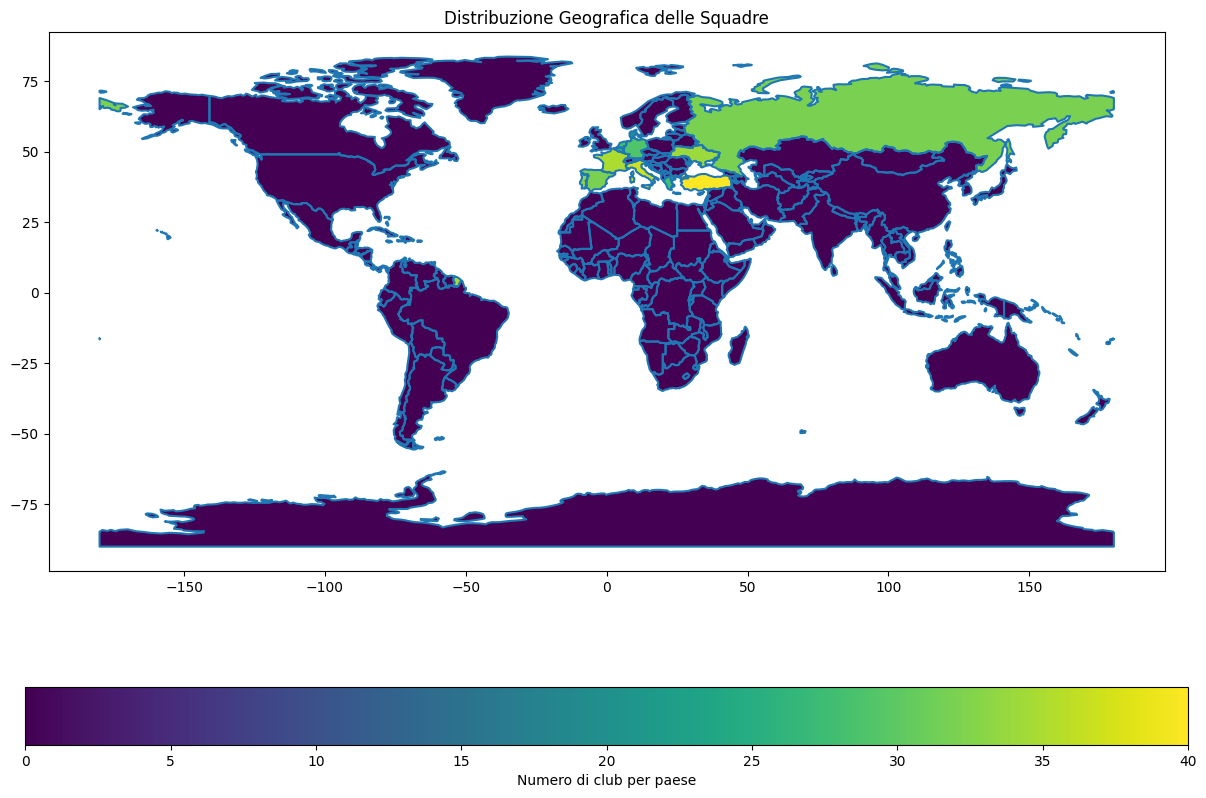

In [3]:

merged_data = pd.merge(dataClubs, dataCompetitions, left_on='domestic_competition_id', right_on='competition_id', how='inner')

# numero di club per paese
country_club_counts = merged_data['country_name'].value_counts().reset_index()
country_club_counts.columns = ['country', 'number_of_clubs']

# geodataframe con i confini dei paesi
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# unione  dei dati dei club con il geodataframe
world_clubs = world.merge(country_club_counts, how="left", left_on="name", right_on="country")

# Impostiamo i valori NaN a 0
world_clubs['number_of_clubs'] = world_clubs['number_of_clubs'].fillna(0)

# Creiamo la mappa
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_clubs.boundary.plot(ax=ax)
world_clubs.plot(column='number_of_clubs', ax=ax, legend=True,
                 legend_kwds={'label': "Numero di club per paese",
                              'orientation': "horizontal"})
plt.title('Distribuzione Geografica delle Squadre')
plt.show()


# 1. Analisi della Performance dei Club
Un'analisi dettagliata delle prestazioni dei club nel calcio

### a. Creazione di una Classifica dei Club basata su Cartellini, Assist e Goal
Generazione di una tabella che classifica i club in base alle prestazioni dei loro giocatori, con un focus sui cartellini gialli, rossi, assist e goal ottenuti.


In [6]:
# Raggruppare i dati per player_id e sommare i valori
stats_sum = dataAppearance.groupby('player_id')[['yellow_cards', 'red_cards', 'goals', 'assists']].sum().reset_index()

# Unire le somme con gli id dei club
player_stats = pd.merge(stats_sum, dataAppearance[['player_id', 'player_club_id', 'player_current_club_id']].drop_duplicates(), on='player_id', how='left')

club_max_red = player_stats.groupby('player_club_id')['red_cards'].max().reset_index()
club_max_goals = player_stats.groupby('player_club_id')[ 'goals'].max().reset_index()
club_max_assists = player_stats.groupby('player_club_id')['assists'].max().reset_index()
club_max_yellow = player_stats.groupby('player_club_id')['yellow_cards'].max().reset_index()

# Unire i risultati in una tabella unica
result = pd.merge(club_max_yellow, club_max_red, on='player_club_id', how='inner')
result = pd.merge(result, club_max_assists, on='player_club_id', how='inner')
result = pd.merge(result, club_max_goals, on='player_club_id', how='inner')

result.columns = ['player_club_id', 'max_yellow_cards', 'max_red_cards', 'max_assists', 'max_goals']

# Visualizzare i club in ordine di massimo numero di cartellini gialli, rossi, assist e goal
result.sort_values(by=['max_yellow_cards', 'max_red_cards', 'max_assists', 'max_goals'], ascending=False, inplace=True)
result = pd.merge(result, dataClubs[['club_id', 'name']], left_on='player_club_id', right_on='club_id', how='left')


# Rimuovere le righe dove 'player_club_id' è NaN
result = result.dropna(subset=['club_id'])

# Rimuovere le righe dove tutti i valori di 'max_yellow_cards', 'max_red_cards', 'max_assists', 'max_goals' sono 0
result = result[~((result['max_yellow_cards'] == 0) & (result['max_red_cards'] == 0) & (result['max_assists'] == 0) & (result['max_goals'] == 0))]

result

,player_club_id,max_yellow_cards,max_red_cards,max_assists,max_goals,club_id,name
0,583,138,6,219,443,583.0,Paris Saint-Germain Football Club
1,418,138,6,161,432,418.0,Real Madrid Club de Fútbol
2,368,138,6,91,250,368.0,Sevilla Fútbol Club S.A.D.
3,131,136,3,219,449,131.0,Futbol Club Barcelona
4,13,130,4,139,283,13.0,Club Atlético de Madrid S.A.D.
...,...,...,...,...,...,...,...
557,724,23,2,20,51,724.0,Football Club Volendam
558,3385,23,1,16,11,3385.0,Panserraikos Serres
568,54189,21,3,43,30,54189.0,Racing White Daring Molenbeek
612,39097,17,1,2,4,39097.0,FK Obolon Kyiv


### b. Analisi della qualità di gioco dei club
Questa serie di grafici a barre presenta una comparazione delle performance di dieci club di calcio in base a quattro metriche chiave: cartellini gialli, cartellini rossi, assist e gol. Ogni grafico mostra i dieci club con i valori più alti per ciascuna metrica. Questa visualizzazione è utile per identificare rapidamente i club che hanno avuto il maggior numero di cartellini gialli e rossi, indicando potenzialmente un gioco più aggressivo, nonché quelli con il maggior numero di assist e gol, evidenziando una forte prestazione offensiva.

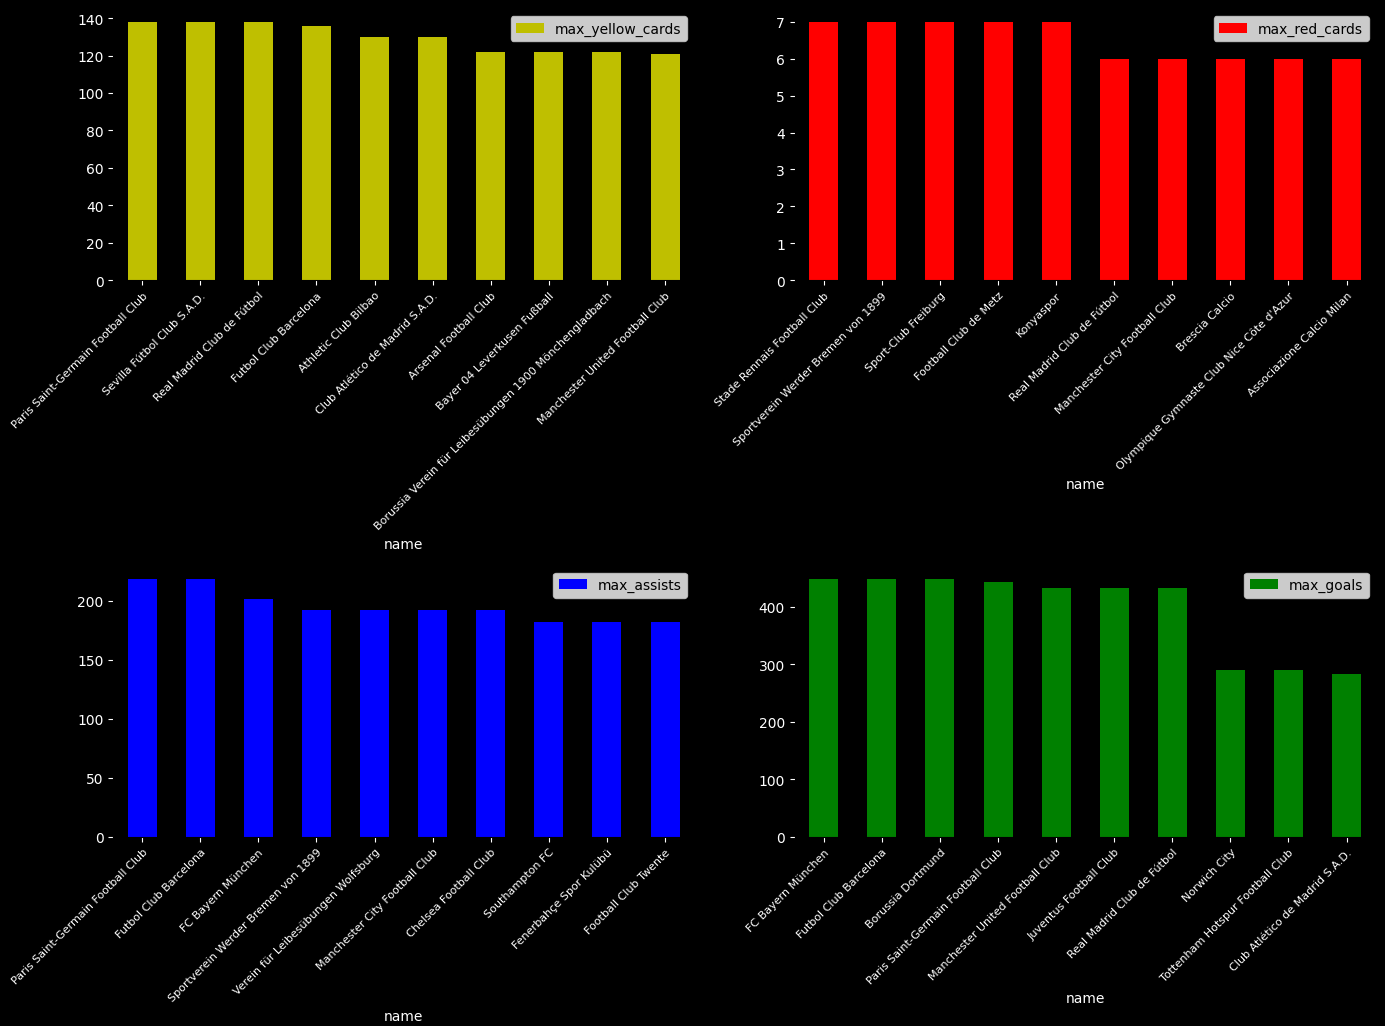

<Figure size 640x480 with 0 Axes>

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), facecolor='black')  # Cambia lo sfondo del figure

text_color = 'white'

# Configurare i subplot
for ax, metric, color in zip(axes.flatten(),
                            ['max_yellow_cards', 'max_red_cards', 'max_assists', 'max_goals'],
                            ['y', 'r', 'b', 'g']):
    
    # Ordinare e creare il grafico a barre
    result.sort_values(metric, ascending=False).head(10).plot(
        x='name', y=metric, kind='bar', ax=ax, color=color
    )
    
    # Cambiare lo sfondo del subplot
    ax.set_facecolor('black')
    
    # Impostare il colore del testo e delle spine per alta visibilità
    ax.tick_params(colors=text_color, which='both')  
    ax.xaxis.label.set_color(text_color)  
    ax.yaxis.label.set_color(text_color)  
    ax.title.set_color(text_color)  
    
    # Imposta i nomi sull'asse x per andare a capo e riduci la dimensione del font
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8, wrap=True)

plt.tight_layout()
plt.show()
result.sort_values('max_yellow_cards', ascending=False).head(10).plot(x='name', y='max_yellow_cards', kind='bar', ax=axes[0, 0], color='y')
result.sort_values('max_red_cards', ascending=False).head(10).plot(x='name', y='max_red_cards', kind='bar', ax=axes[0, 1], color='r')
result.sort_values('max_assists', ascending=False).head(10).plot(x='name', y='max_assists', kind='bar', ax=axes[1, 0], color='b')
result.sort_values('max_goals', ascending=False).head(10).plot(x='name', y='max_goals', kind='bar', ax=axes[1, 1], color='g')
plt.tight_layout()
plt.show()

#### Cartellini Gialli: 
Alcuni club tendono ad avere un numero significativamente più alto di cartellini gialli, potenzialmente indicando uno stile di gioco più fisico o una disciplina tattica minore.

#### Cartellini Rossi:
 I cartellini rossi sono distribuiti in modo più uniforme tra i club rispetto ai cartellini gialli, ma comunque alcuni club spiccano per avere un numero maggiore, che potrebbe influenzare negativamente la loro capacità di competere con il massimo dei giocatori in campo.

#### Assist:
 L'assistenza nei gol è piuttosto bilanciata tra i club, con solo leggere variazioni nel numero di assist, suggerendo una distribuzione di abilità nella creazione di opportunità di gol.

#### Gol:
 I gol, come gli assist, sono distribuiti in modo abbastanza uniforme tra i club, con alcune squadre che spiccano leggermente per il loro potenziale offensivo.

### c. Identifico il club che ha ottenuto il maggior numero di cartellini rossi, gialli, assist e goal dai propri giocatori, suddivisi per anno.

In [12]:
dataAppearance['year'] = pd.to_datetime(dataAppearance['date']).dt.year

# Raggruppare i dati per player_club_id e anno
grouped_data = dataAppearance.groupby(['player_club_id', 'year'])

# Calcolare i valori massimi per ogni club e anno
club_year_max_red = grouped_data['red_cards'].max().reset_index()
club_year_max_goals = grouped_data['goals'].max().reset_index()
club_year_max_assists = grouped_data['assists'].max().reset_index()
club_year_max_yellow = grouped_data['yellow_cards'].max().reset_index()

# Unire i risultati in una tabella unica
result = pd.merge(club_year_max_yellow, club_year_max_red, on=['player_club_id', 'year'], how='inner')
result = pd.merge(result, club_year_max_assists, on=['player_club_id', 'year'], how='inner')
result = pd.merge(result, club_year_max_goals, on=['player_club_id', 'year'], how='inner')

# Rinominare le colonne per chiarezza
result.columns = ['player_club_id', 'year', 'max_yellow_cards', 'max_red_cards', 'max_assists', 'max_goals']

# Visualizzare i club in ordine di massimo numero di cartellini gialli, rossi, assist e goal per anno
result.sort_values(by=['year', 'max_yellow_cards', 'max_red_cards', 'max_assists', 'max_goals'], ascending=[False, False, False, False, False], inplace=True)
result = pd.merge(result, dataClubs[['club_id', 'name']], left_on='player_club_id', right_on='club_id', how='left')


# Rimuovere le righe dove 'player_club_id' è NaN
result = result.dropna(subset=['club_id'])

# Rimuovere le righe dove tutti i valori di 'max_yellow_cards', 'max_red_cards', 'max_assists', 'max_goals' sono 0
result = result[~((result['max_yellow_cards'] == 0) & (result['max_red_cards'] == 0) & (result['max_assists'] == 0) & (result['max_goals'] == 0))]

# Visualizzare il risultato finale
result

,player_club_id,year,max_yellow_cards,max_red_cards,max_assists,max_goals,club_id,name
0,281,2023,2,1,4,5,281.0,Manchester City Football Club
1,3709,2023,2,1,4,3,3709.0,Getafe Club de Fútbol S.A.D. Team Dubai
2,1041,2023,2,1,3,4,1041.0,Olympique Lyonnais
3,11,2023,2,1,3,3,11.0,Arsenal Football Club
4,265,2023,2,1,3,3,265.0,Panathinaikos Athlitikos Omilos
...,...,...,...,...,...,...,...,...
5298,472,2012,0,0,1,1,472.0,Unión Deportiva Las Palmas S.A.D.
5303,2999,2012,0,0,1,0,2999.0,Hamilton Academical FC
5308,350,2012,0,0,0,1,350.0,Sheffield United Football Club
5316,5358,2012,0,0,0,1,5358.0,SD Huesca




### d. Questo grafico mette in luce le squadre che nel corso degli anni hanno mostrato un miglioramento significativo nella qualità del gioco, ossia una diminuzione delle infrazioni commesse e un aumento nella produzione di goal e assist. 

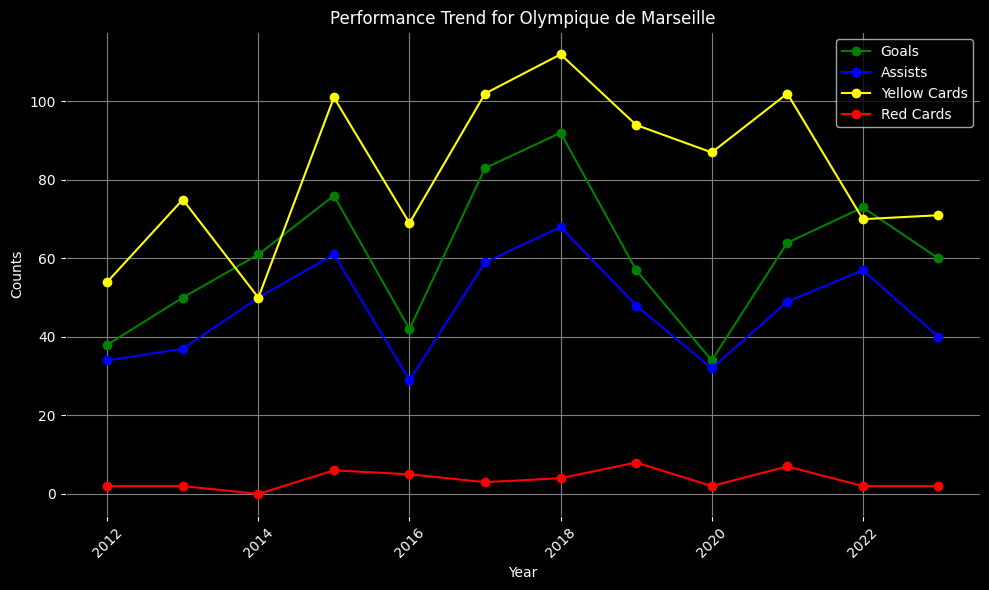

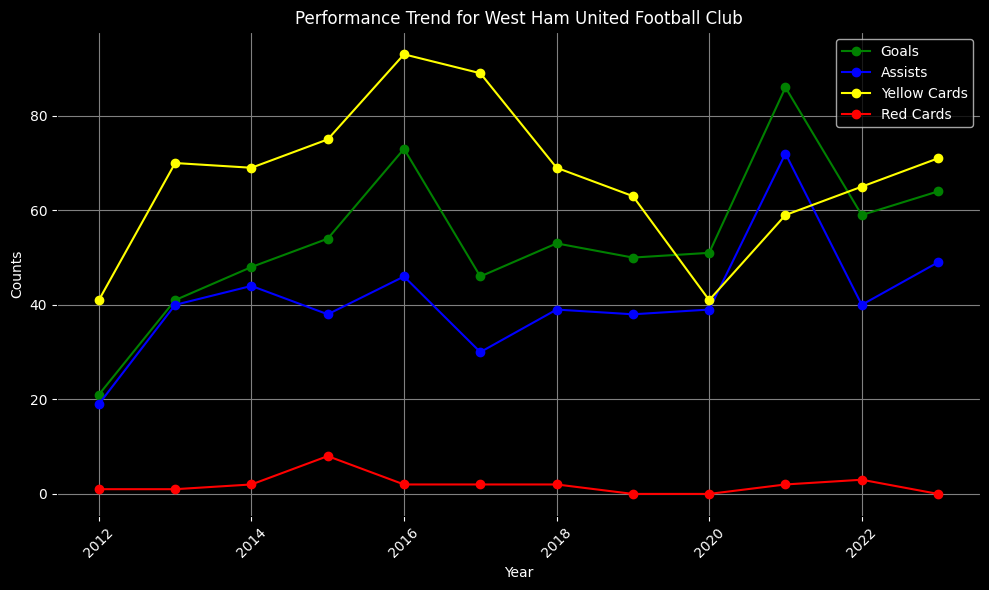

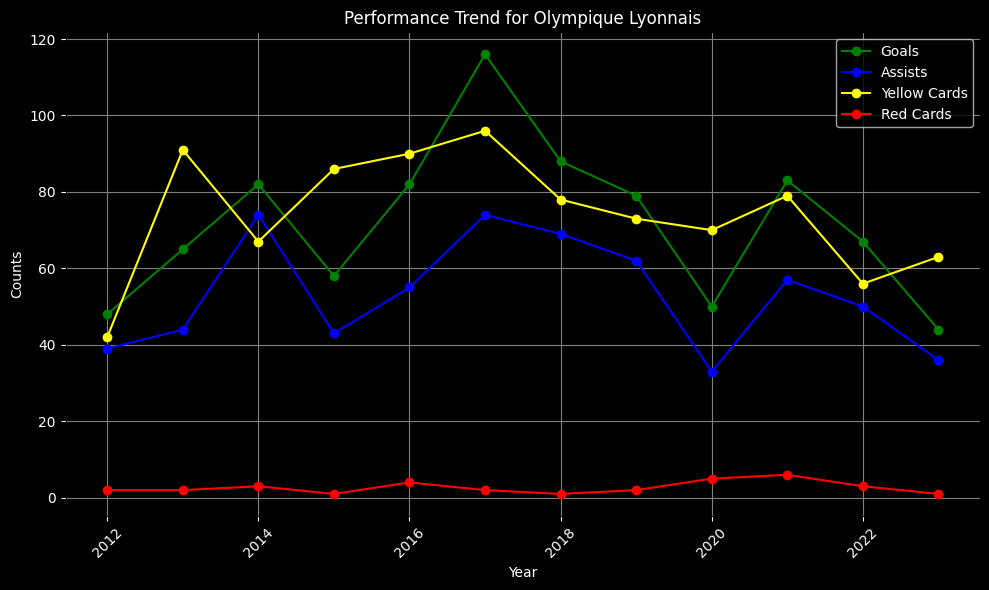

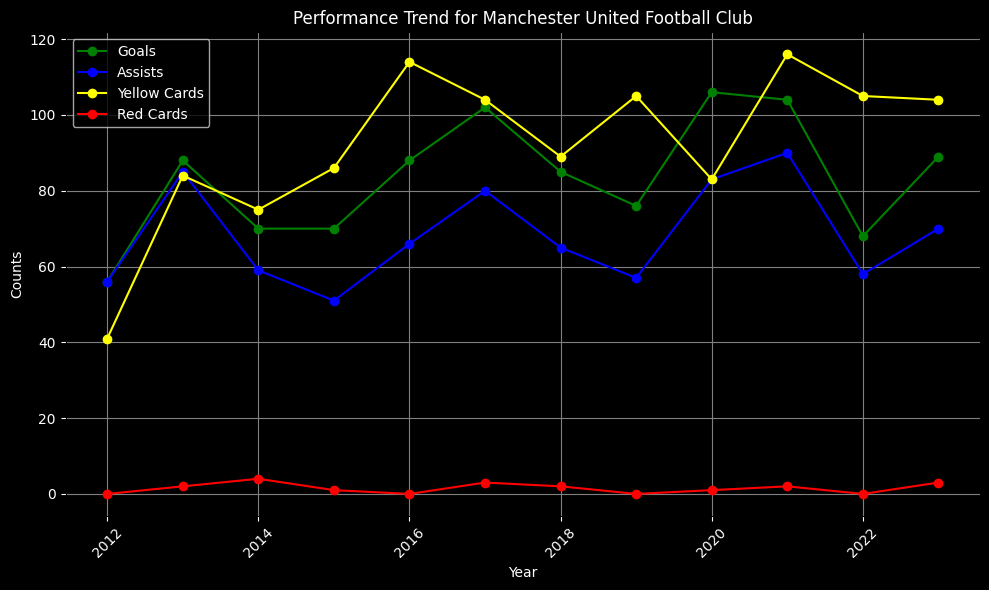

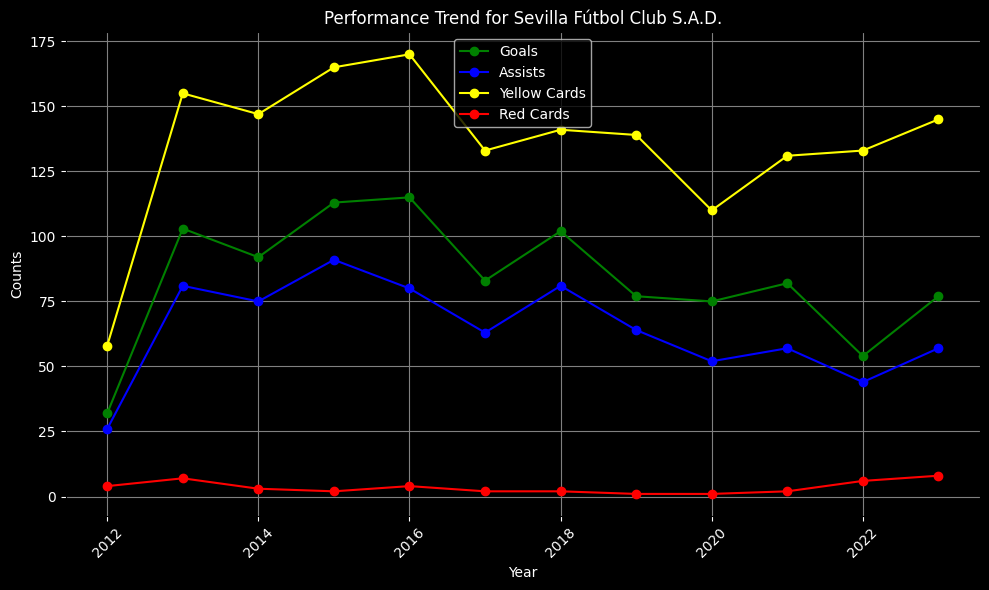

In [14]:
club_year_sum = grouped_data[['yellow_cards', 'red_cards', 'goals', 'assists']].sum().reset_index()
club_year_sum = pd.merge(club_year_sum, dataClubs[['club_id', 'name']], left_on='player_club_id', right_on='club_id', how='left')

# Rimuovere le righe con valori NaN o 0 per tutte le metriche
club_year_sum = club_year_sum.dropna(subset=['club_id'])
club_year_sum = club_year_sum[~((club_year_sum['yellow_cards'] == 0) & (club_year_sum['red_cards'] == 0) & (club_year_sum['assists'] == 0) & (club_year_sum['goals'] == 0))]

# Impostazioni per lo sfondo nero e il testo bianco
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['figure.facecolor'] = 'black'

# Selezionare un sottoinsieme di club per la visualizzazione 
top_clubs = club_year_sum['name'].value_counts().index[:5]
club_year_sum = club_year_sum[club_year_sum['name'].isin(top_clubs)]

for club in top_clubs:
    club_data = club_year_sum[club_year_sum['name'] == club].sort_values('year')
    plt.figure(figsize=(10, 6))
    
    plt.gca().set_facecolor('black')
    
    plt.plot(club_data['year'], club_data['goals'], label='Goals', color='green', marker='o')
    plt.plot(club_data['year'], club_data['assists'], label='Assists', color='blue', marker='o')
    plt.plot(club_data['year'], club_data['yellow_cards'], label='Yellow Cards', color='yellow', marker='o')
    plt.plot(club_data['year'], club_data['red_cards'], label='Red Cards', color='red', marker='o')
    
    plt.title(f'Performance Trend for {club}', color='white')
    plt.xlabel('Year')
    plt.ylabel('Counts')
    plt.xticks(rotation=45)  # Ruota le etichette dell'asse x
    plt.legend()
    plt.grid(True, color='gray')  # Griglia con colore per alta visibilità
    plt.tight_layout()
    plt.show()

# 2. Analisi delle performance dei club 
valutazione delle performance dei club complessiva dei games vinti, pareggiati e persi, viene stilata una classifica in cui viene valutato il club che complessivamente ha performato nel miglior modo, quindi con il maggior numero di partite vinte e il minor numero di partite perse o pareggiate 

In [15]:
home_games = pd.merge(dataClubs, dataGames, left_on='club_id', right_on='home_club_id', how='left')

# Merge quando il club è la squadra ospite
away_games = pd.merge(dataClubs, dataGames, left_on='club_id', right_on='away_club_id', how='left')

# Concatenare i risultati
club_games_details = pd.concat([home_games, away_games], ignore_index=True)

# Aggiungere colonne per vittorie, pareggi e sconfitte
club_games_details['win'] = 0
club_games_details['draw'] = 0
club_games_details['loss'] = 0

club_games_details.loc[(club_games_details['club_id'] == club_games_details['home_club_id']) & 
                       (club_games_details['home_club_goals'] > club_games_details['away_club_goals']), 'win'] = 1
club_games_details.loc[(club_games_details['club_id'] == club_games_details['away_club_id']) & 
                       (club_games_details['away_club_goals'] > club_games_details['home_club_goals']), 'win'] = 1
club_games_details.loc[(club_games_details['home_club_goals'] == club_games_details['away_club_goals']), 'draw'] = 1
club_games_details.loc[(club_games_details['club_id'] == club_games_details['home_club_id']) & 
                       (club_games_details['home_club_goals'] < club_games_details['away_club_goals']), 'loss'] = 1
club_games_details.loc[(club_games_details['club_id'] == club_games_details['away_club_id']) & 
                       (club_games_details['away_club_goals'] < club_games_details['home_club_goals']), 'loss'] = 1

# Ricreare la tabella riassuntiva per i club
club_performance = club_games_details.groupby('club_id').agg(
    wins=pd.NamedAgg(column='win', aggfunc='sum'),
    draws=pd.NamedAgg(column='draw', aggfunc='sum'),
    losses=pd.NamedAgg(column='loss', aggfunc='sum')
).reset_index()

# Unire con i nomi dei club
club_performance = club_performance.merge(dataClubs[['club_id', 'name']], on='club_id', how='left')

# Ordinare i club per vittorie, poi pareggi, e infine minor numero di sconfitte
club_performance_sorted = club_performance.sort_values(by=['wins', 'draws', 'losses'], ascending=[False, False, True])

club_performance_sorted


,club_id,wins,draws,losses,name
15,27,443,72,70,FC Bayern München
45,131,435,108,92,Futbol Club Barcelona
106,418,433,104,100,Real Madrid Club de Fútbol
75,281,414,90,107,Manchester City Football Club
119,506,402,101,101,Juventus Football Club
...,...,...,...,...,...
418,54189,4,5,6,Racing White Daring Molenbeek
269,2431,4,3,10,Club Football Estrela da Amadora
152,738,3,7,3,Le Havre Athletic Club
308,3209,3,4,6,Pendikspor


# a. Percentuale di Vittorie, Pareggi e Sconfitte per Club
Analizzare la percentuale di vittorie, pareggi e sconfitte rispetto al totale delle partite giocate per ciascun club.

Codice per il Calcolo delle Percentuali:

In [17]:
club_performance_sorted['total_games'] = club_performance_sorted['wins'] + club_performance_sorted['draws'] + club_performance_sorted['losses']
club_performance_sorted['win_percentage'] = club_performance_sorted['wins'] / club_performance_sorted['total_games'] * 100
club_performance_sorted['draw_percentage'] = club_performance_sorted['draws'] / club_performance_sorted['total_games'] * 100
club_performance_sorted['loss_percentage'] = club_performance_sorted['losses'] / club_performance_sorted['total_games'] * 100


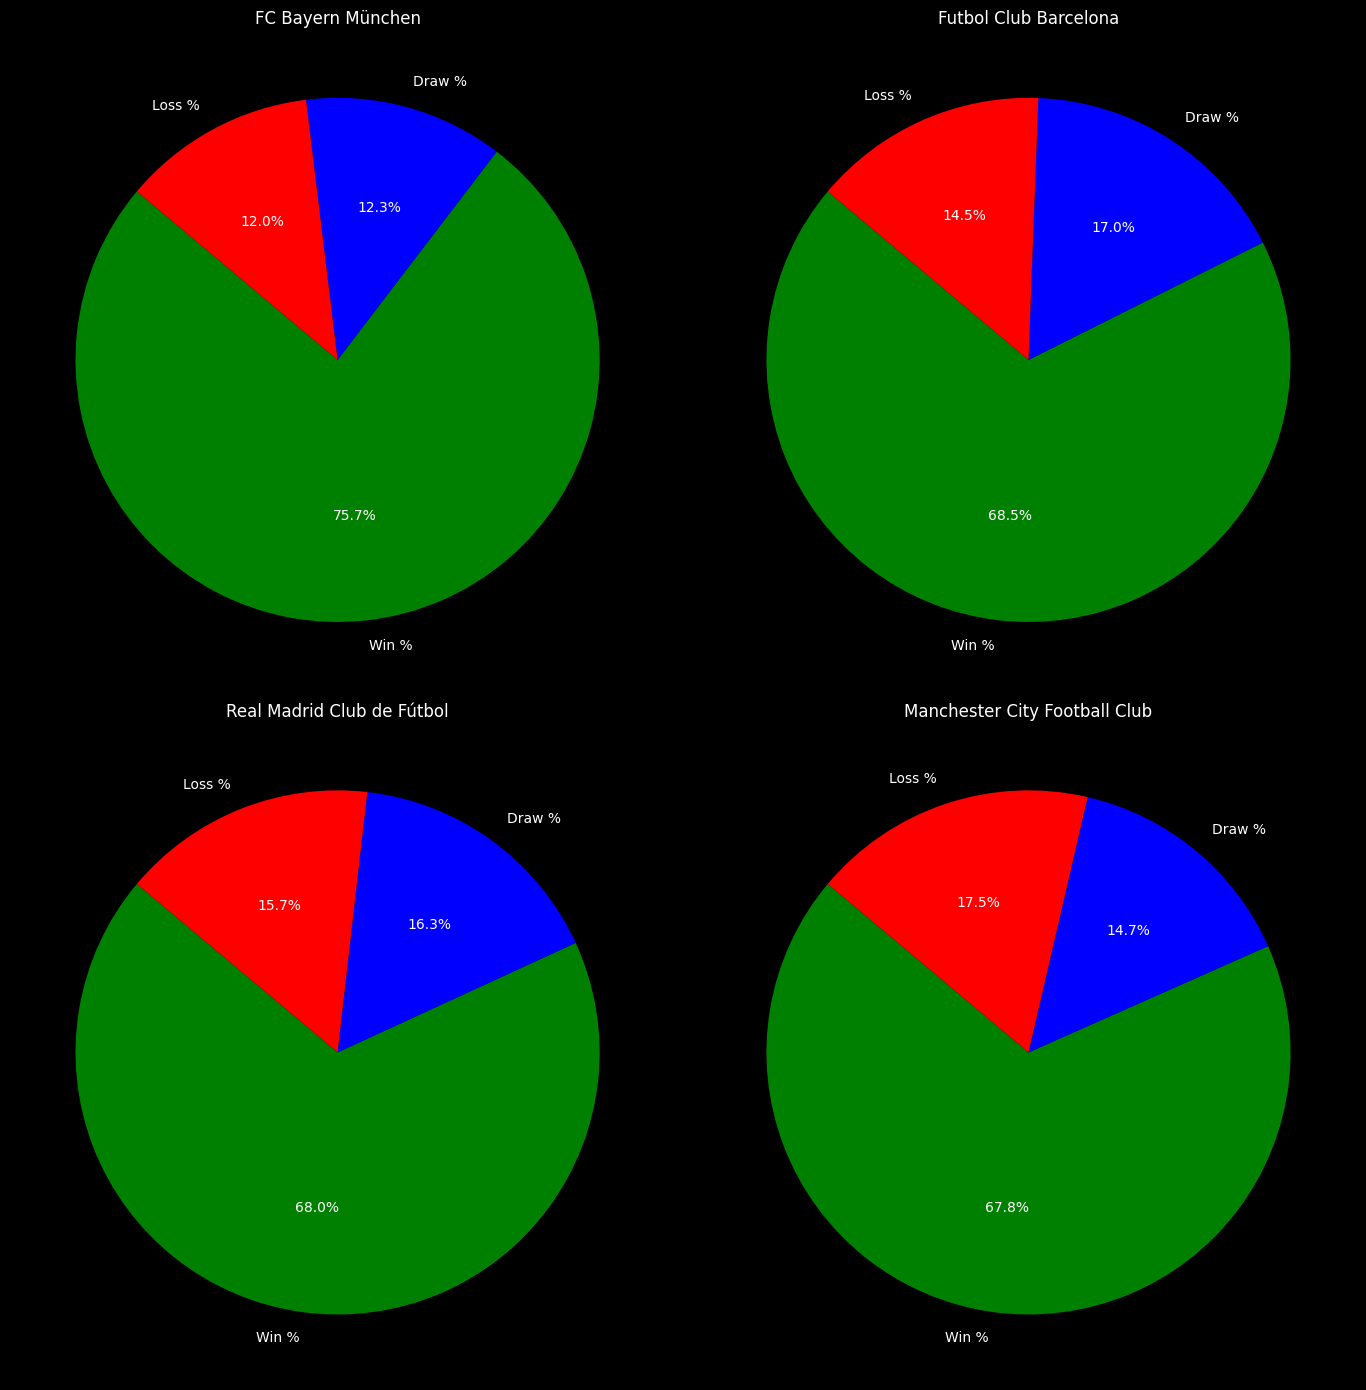

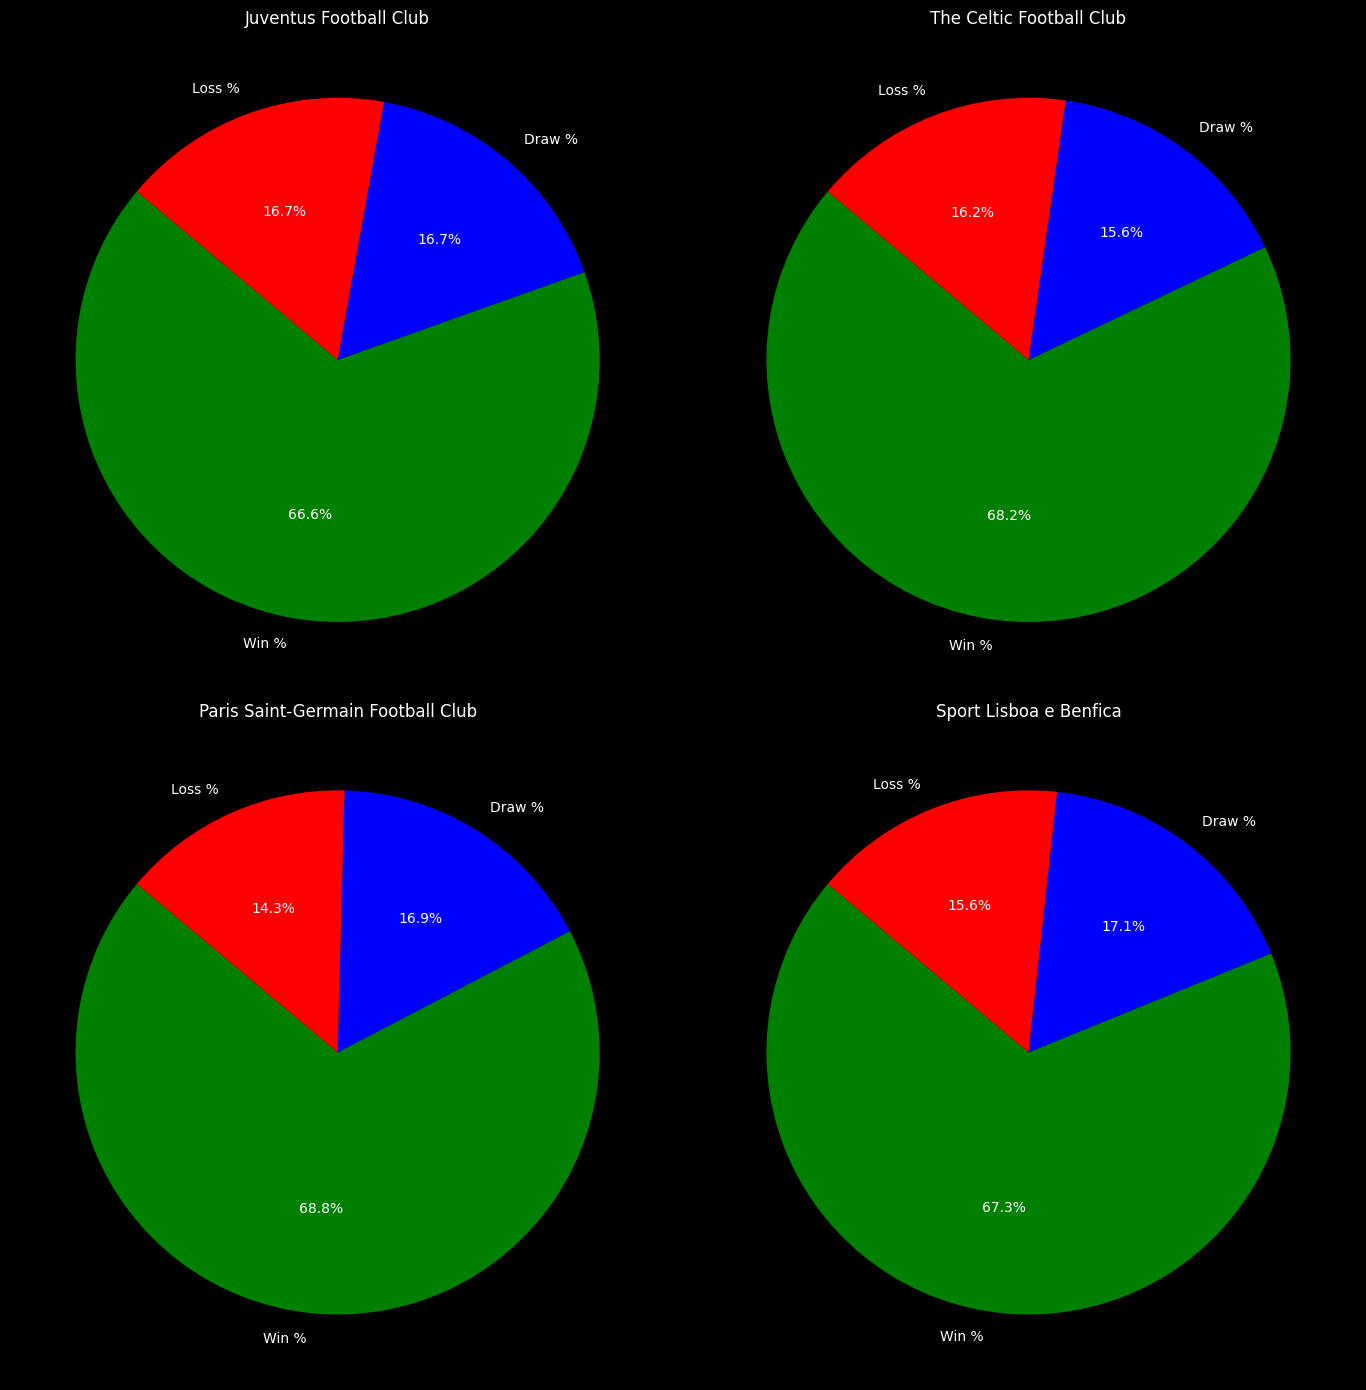

In [18]:

# Selezionare le prime 8 squadre
top_clubs = club_performance_sorted.head(8)

# Impostazioni per i colori dei segmenti
colors = ['green', 'blue', 'red']
labels = ['Win %', 'Draw %', 'Loss %']

fig1, axs1 = plt.subplots(2, 2, figsize=(14, 14))
axs1 = axs1.flatten()  # Appiattire l'array di assi per un più facile accesso

for i, ax in enumerate(axs1):
    club = top_clubs.iloc[i]
    sizes = [club['win_percentage'], club['draw_percentage'], club['loss_percentage']]
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    ax.set_title(club['name'])

plt.tight_layout()
plt.show()

fig2, axs2 = plt.subplots(2, 2, figsize=(14, 14))
axs2 = axs2.flatten()  # Appiattire l'array di assi per un più facile accesso

for i, ax in enumerate(axs2):
    club = top_clubs.iloc[i + 4]  
    sizes = [club['win_percentage'], club['draw_percentage'], club['loss_percentage']]
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    ax.set_title(club['name'])

plt.tight_layout()
plt.show()

### b. Trend delle Vittorie e delle Sconfitte nel Tempo per i Club migliori 
Mostrare il trend delle vittorie e delle sconfitte nel corso degli anni per i club con il maggior numero di vittorie.


In [19]:
# Assumiamo che 'dataGames' sia il tuo DataFrame
dataGames['year'] = pd.to_datetime(dataGames['date']).dt.year

# Calcolare vittorie, pareggi e sconfitte per ogni partita
dataGames['home_win'] = dataGames['home_club_goals'] > dataGames['away_club_goals']
dataGames['away_win'] = dataGames['away_club_goals'] > dataGames['home_club_goals']
dataGames['draw'] = dataGames['home_club_goals'] == dataGames['away_club_goals']

# Raggruppare per club_id e anno, calcolare il totale per ogni categoria
home_performance = dataGames.groupby(['home_club_id', 'year']).agg(
    home_wins=pd.NamedAgg(column='home_win', aggfunc='sum'),
    home_draws=pd.NamedAgg(column='draw', aggfunc='sum'),
    home_losses=pd.NamedAgg(column='away_win', aggfunc='sum')  # Sconfitte in casa equivalgono a vittorie fuori casa
).reset_index()

away_performance = dataGames.groupby(['away_club_id', 'year']).agg(
    away_wins=pd.NamedAgg(column='away_win', aggfunc='sum'),
    away_draws=pd.NamedAgg(column='draw', aggfunc='sum'),
    away_losses=pd.NamedAgg(column='home_win', aggfunc='sum')  # Sconfitte fuori casa equivalgono a vittorie in casa
).reset_index()

# Unire i risultati di casa e fuori casa
total_performance = pd.merge(
    home_performance, 
    away_performance, 
    left_on=['home_club_id', 'year'], 
    right_on=['away_club_id', 'year'], 
    how='outer',
    suffixes=('_home', '_away')
)

# Calcolare il totale di vittorie, pareggi e sconfitte
total_performance['total_wins'] = total_performance['home_wins'].fillna(0) + total_performance['away_wins'].fillna(0)
total_performance['total_draws'] = total_performance['home_draws'].fillna(0) + total_performance['away_draws'].fillna(0)
total_performance['total_losses'] = total_performance['home_losses'].fillna(0) + total_performance['away_losses'].fillna(0)

# Selezionare e rinominare le colonne rilevanti
total_performance = total_performance[['home_club_id', 'year', 'total_wins', 'total_draws', 'total_losses']]
total_performance = total_performance.rename(columns={'home_club_id': 'club_id'})

# Ordinare per club_id e anno
total_performance = total_performance.sort_values(by=['year'])

# Rimuovere le righe dove 'player_club_id' è NaN
total_performance = total_performance.dropna(subset=['club_id'])

# Unire con i nomi dei club
total_performance = total_performance.merge(dataClubs[['club_id', 'name']], on='club_id', how='left')

# Visualizzare solo i club di cui ho i nomi 
total_performance = total_performance.dropna(subset=['name'])

# Visualizzare il risultato
total_performance

,club_id,year,total_wins,total_draws,total_losses,name
3,1123.0,2012,6.0,7.0,7.0,Norwich City
6,1124.0,2012,1.0,0.0,1.0,FK Fakel Voronezh
8,180.0,2012,4.0,5.0,10.0,Southampton FC
10,1147.0,2012,5.0,6.0,8.0,AC Ajaccio
11,12438.0,2012,4.0,5.0,11.0,Volga Nizhniy Novgorod (- 2016)
...,...,...,...,...,...,...
10742,237.0,2023,12.0,11.0,17.0,Real Club Deportivo Mallorca S.A.D.
10748,1148.0,2023,15.0,10.0,12.0,Brentford Football Club
10749,244.0,2023,18.0,11.0,12.0,Olympique de Marseille
10751,1147.0,2023,3.0,2.0,17.0,AC Ajaccio


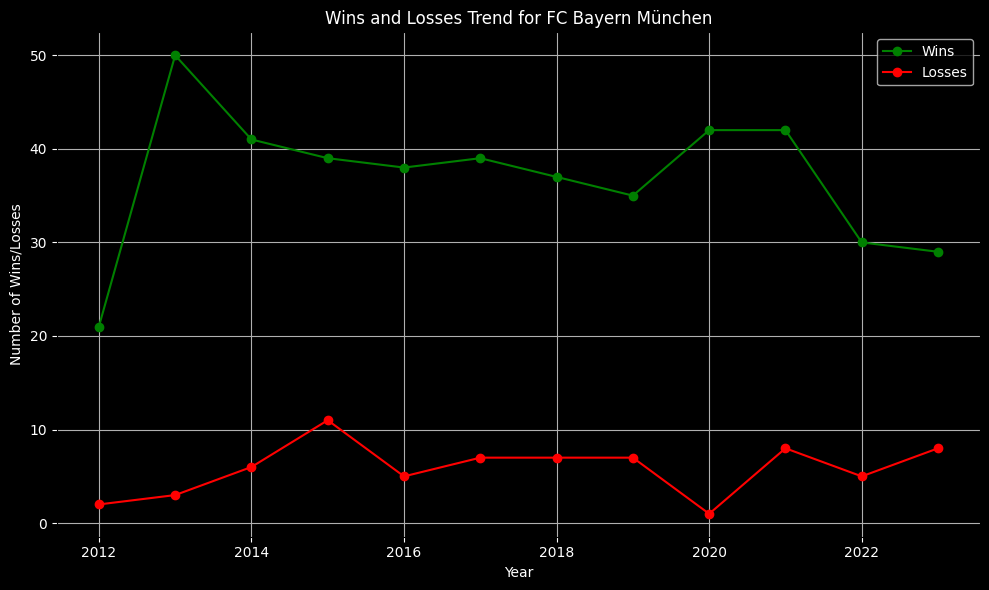

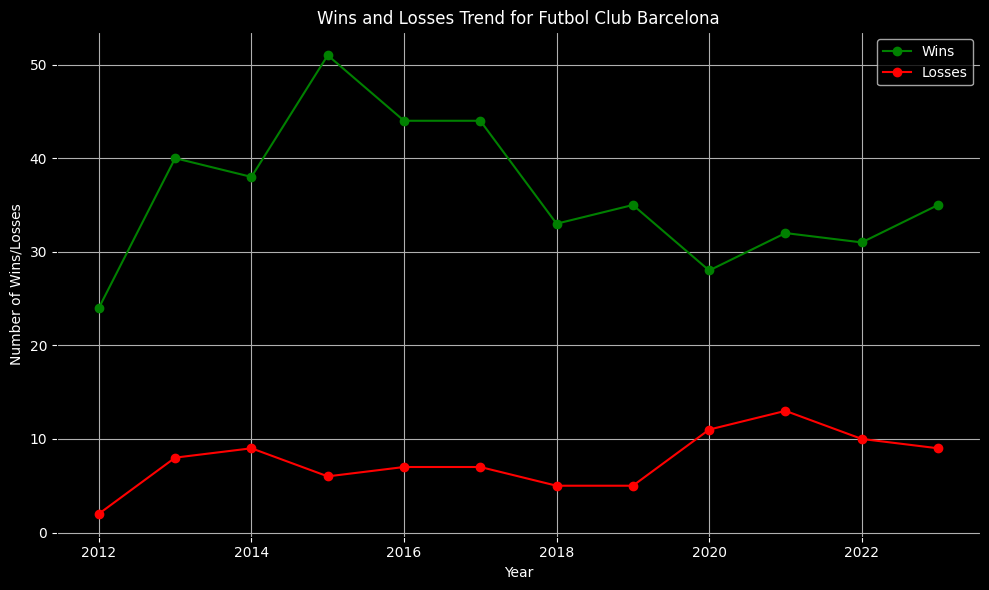

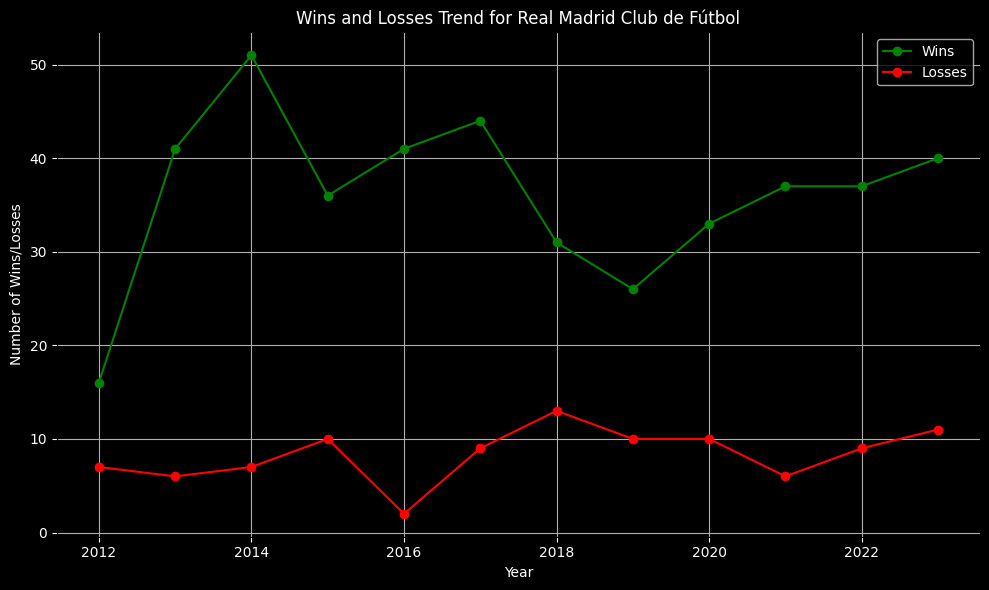

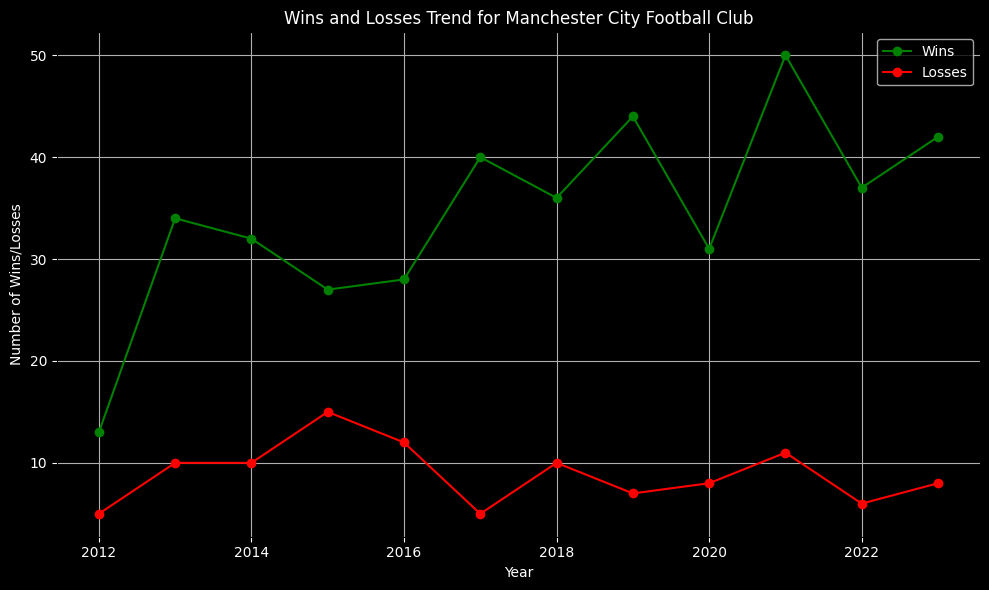

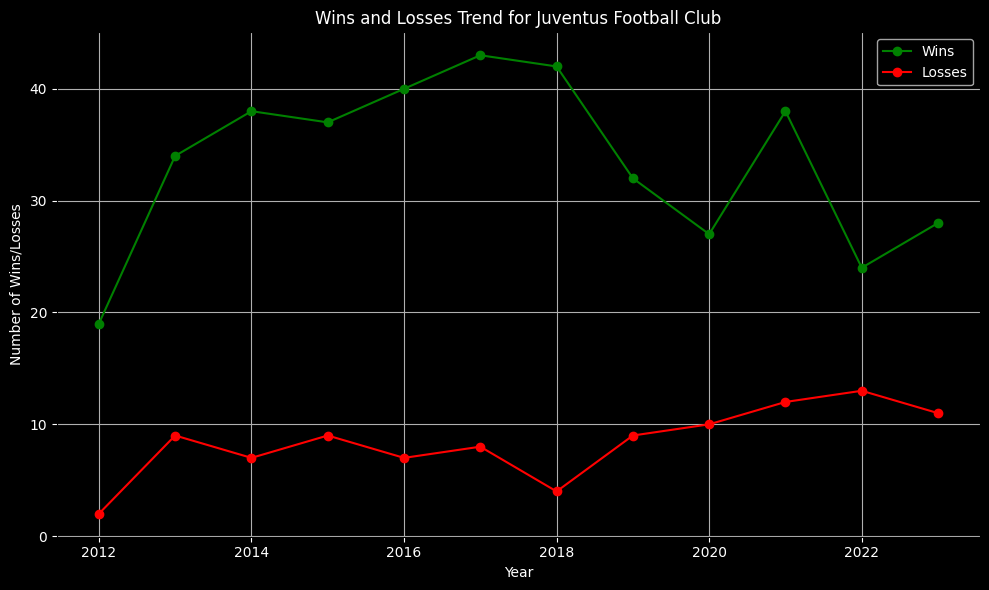

In [20]:
top_clubs = club_performance_sorted.head(5)['name']  # Top 5 club per numero di vittorie

for club in top_clubs:
    club_data = total_performance[total_performance['name'] == club]
    plt.figure(figsize=(10, 6))
    
    plt.plot(club_data['year'], club_data['total_wins'], label='Wins', color='green', marker='o')
    plt.plot(club_data['year'], club_data['total_losses'], label='Losses', color='red', marker='o')
    
    plt.title(f'Wins and Losses Trend for {club}')
    plt.xlabel('Year')
    plt.ylabel('Number of Wins/Losses')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### c. Analisi dei dati relativi ai goal in casa e fuori casa 

differenza tra le prestazioni in casa e fuori casa in dei club con una visione riguardo agli ultimi anni di gioco dei club (2020-2023)

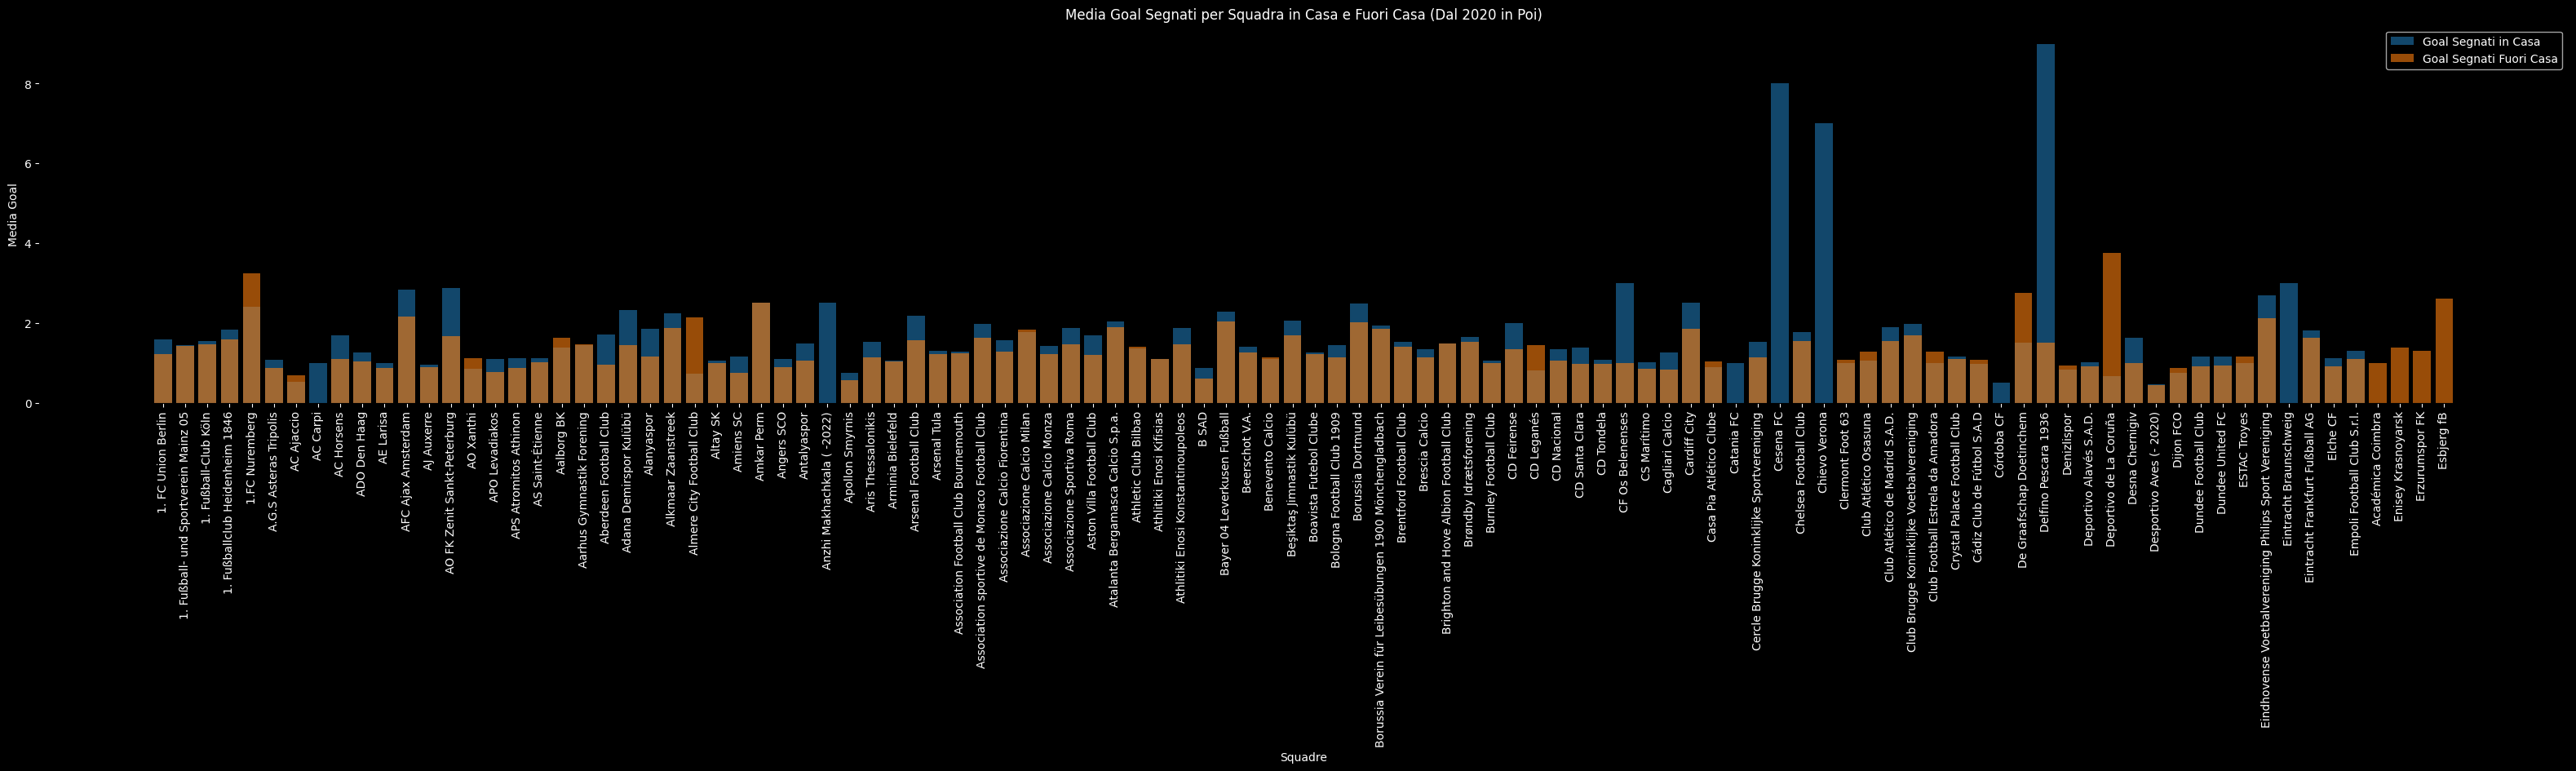

In [22]:
dataGames['date'] = pd.to_datetime(dataGames['date'])

dataGames_2020_onwards = dataGames[dataGames['date'].dt.year >= 2020]

# Calcola la media dei goal in casa per ogni squadra
home_goals_mean = dataGames_2020_onwards.groupby("home_club_name")["home_club_goals"].mean().head(100)

# Calcola la media dei goal fuori casa per ogni squadra
away_goals_mean = dataGames_2020_onwards.groupby("away_club_name")["away_club_goals"].mean().head(100)

plt.figure(figsize=(40, 6))
plt.bar(home_goals_mean.index, home_goals_mean, label="Goal Segnati in Casa", alpha=0.6)
plt.bar(away_goals_mean.index, away_goals_mean, label="Goal Segnati Fuori Casa", alpha=0.6)
plt.xticks(rotation=90)
plt.xlabel("Squadre")
plt.ylabel("Media Goal")
plt.legend()
plt.title("Media Goal Segnati per Squadra in Casa e Fuori Casa (Dal 2020 in Poi)")
plt.show()

# 2. Analisi delle Formazioni e delle Posizioni dei Giocatori
Utilizzeremo il dataset dataGamesLineups per analizzare come le formazioni e le posizioni dei giocatori influenzano le prestazioni della squadra.


### a. Analisi della Distribuzione delle Posizioni:

Ogni grafico radar rappresenta visivamente la frequenza dei giocatori in ogni posizione per un singolo club.
I diversi assi del grafico rappresentano le diverse posizioni (ad esempio, attaccante, difensore, centrocampista).
La lunghezza di ogni asse del grafico indica il numero di giocatori in quella specifica posizione nel club.

Confrontando i grafici radar dei diversi club, puoi identificare quali posizioni sono più o meno popolate in ciascun club.
Questo può indicare, ad esempio, una tendenza di un club a investire più in attaccanti piuttosto che in difensori, o viceversa.

Le informazioni derivanti dai grafici possono essere utili per il management dei club per valutare l'equilibrio della squadra, identificare le aree che necessitano di rinforzi e pianificare trasferimenti o strategie di formazione.
Gli allenatori possono utilizzare queste informazioni per comprendere meglio la composizione della squadra e per sviluppare strategie di gioco che sfruttino i punti di forza o mitigino le debolezze.

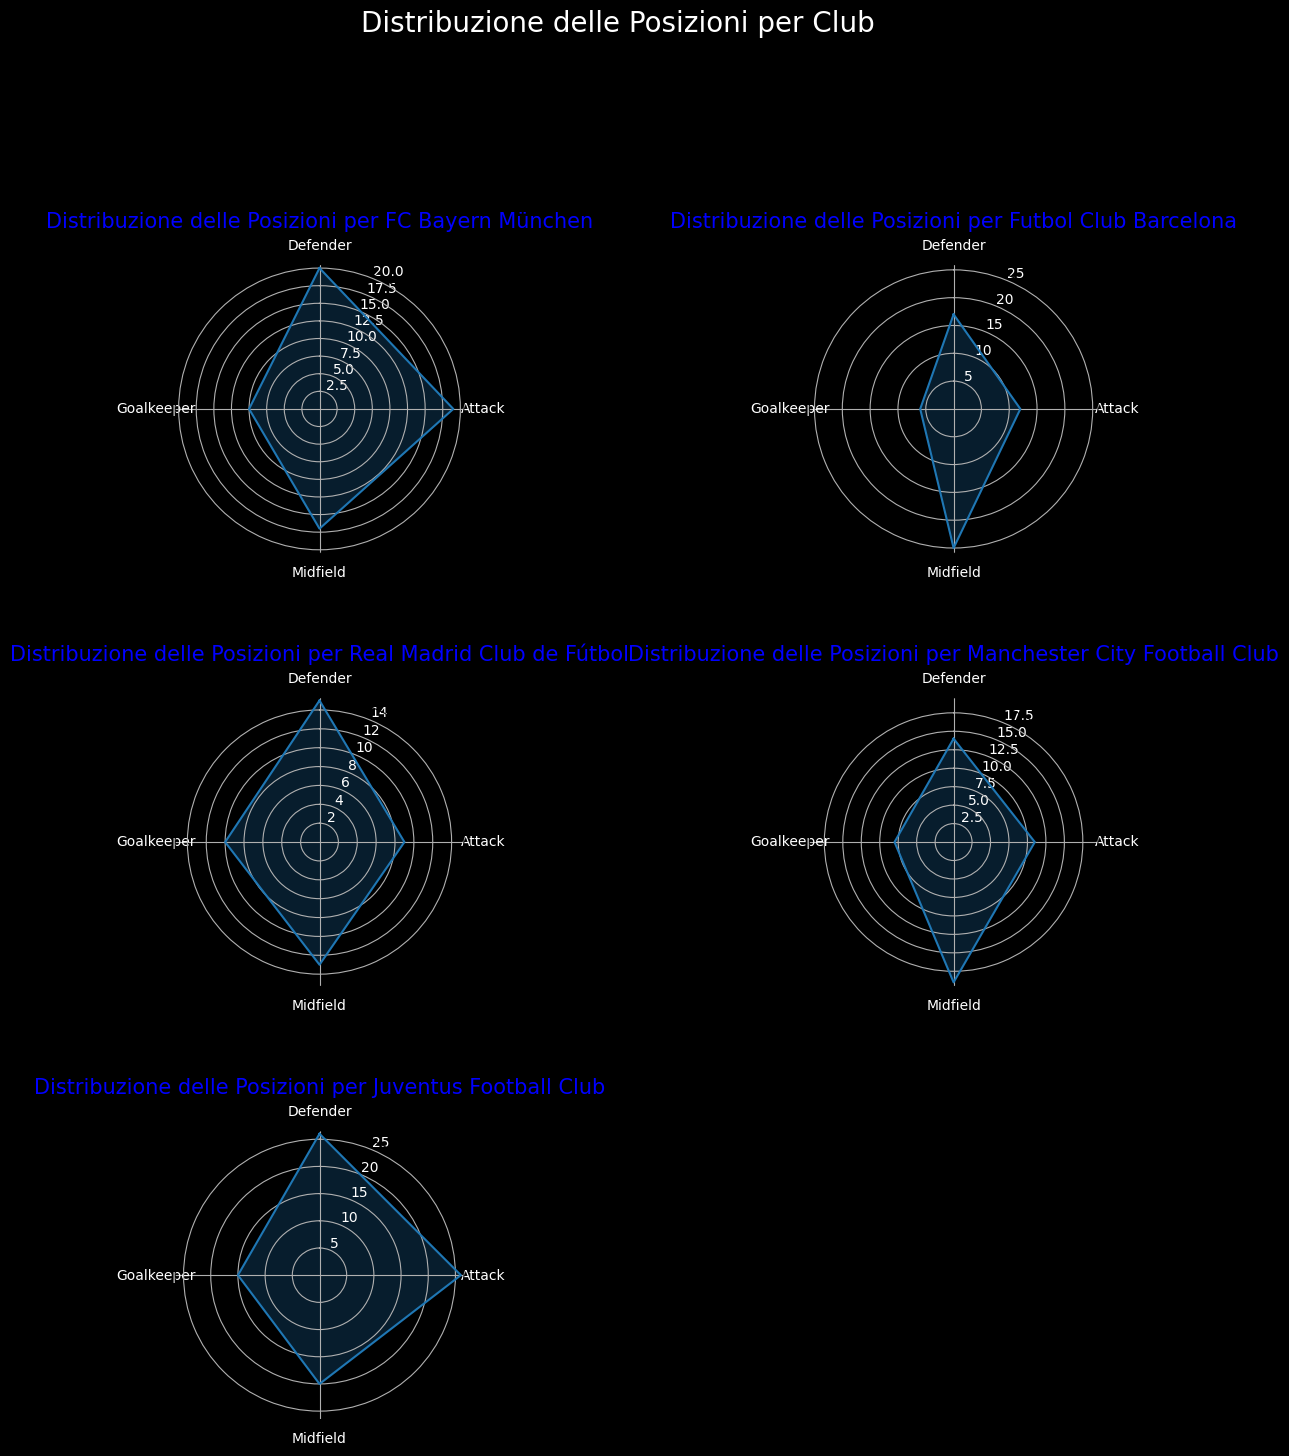

In [23]:
top_club_ids = club_performance_sorted['club_id'].head(5).tolist()

#filtra i giocatori che giocano per i club top
top_club_players = dataPlayers[dataPlayers['current_club_id'].isin(top_club_ids)]

positions = top_club_players['position'].unique()
dataPosition = pd.merge(top_club_players, club_performance_sorted[['club_id', 'name']].head(5), left_on='current_club_id', right_on='club_id', how='left')

# Creare un radar chart per ogni club
num_vars = len(positions)
angles = np.linspace(0, 2 * pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

#layout del grafico
fig, axes = plt.subplots(figsize=(15, 15), nrows=3, ncols=2, subplot_kw=dict(polar=True))
axes = axes.flatten() 

for idx, club_id in enumerate(top_club_ids):
    ax = axes[idx]
    club_name = club_performance_sorted[club_performance_sorted['club_id'] == club_id]['name'].values[0]
    club_data = dataPosition[dataPosition['current_club_id'] == club_id]
    values = [club_data[club_data['position'] == pos].shape[0] for pos in positions]
    values += values[:1]
    ax.fill(angles, values, alpha=0.25)
    ax.plot(angles, values, label=f'{club_name}')
    ax.set_title(f'Distribuzione delle Posizioni per {club_name}', size=15, color='blue', y=1.1)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), positions)

for ax in axes[idx+1:]:
    ax.remove()

plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.suptitle('Distribuzione delle Posizioni per Club', size=20, y=1.05)
plt.show()


# 1. Frequenza delle diverse formazioni usate dai club
Iniziamo calcolando la frequenza delle diverse formazioni usate dai club e visualizziamole con un grafico a barre.

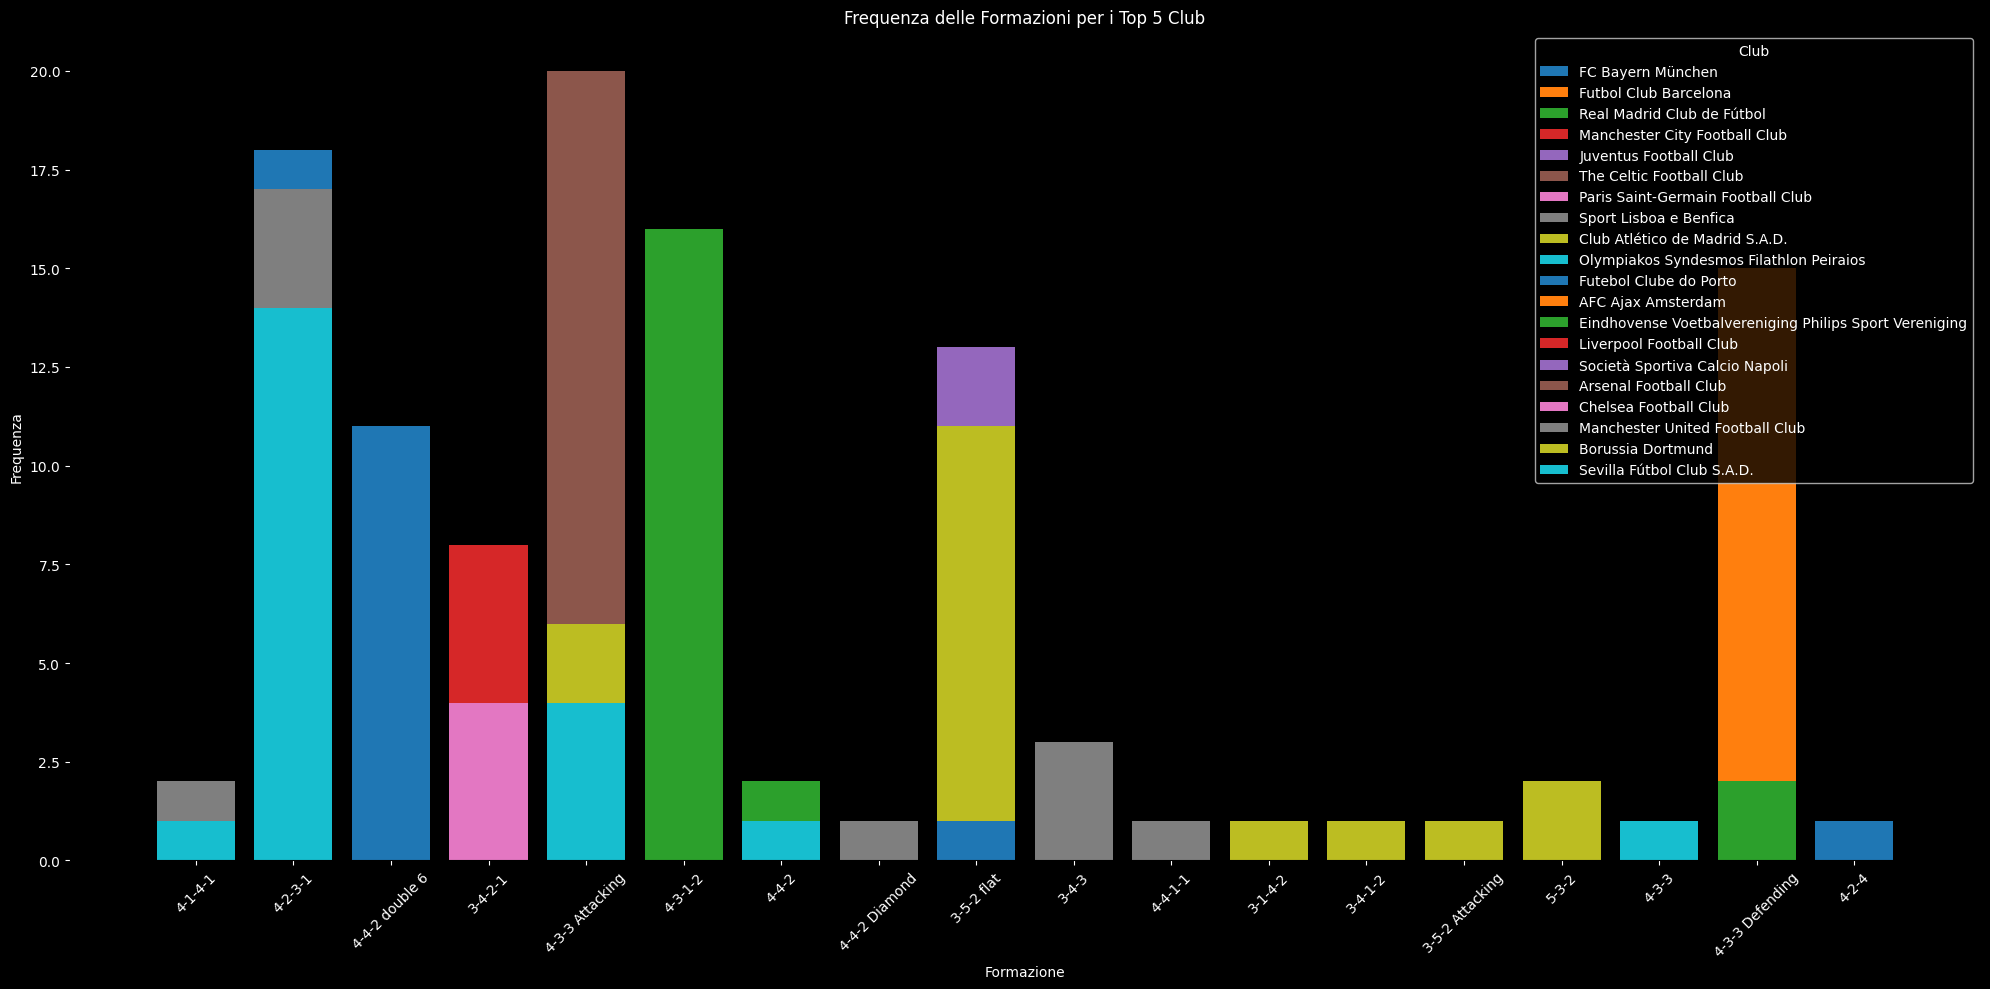

In [24]:

# Estrarre i nomi dei primi 5 club dalla classifica
top_5_clubs = club_performance_sorted.head(20)['name'].tolist()

# Filtrare i giochi che coinvolgono solo i primi 5 club
top_club_games = dataGames[(dataGames['home_club_name'].isin(top_5_clubs)) | (dataGames['away_club_name'].isin(top_5_clubs))]

formations_freq_home = top_club_games.groupby(['home_club_name', 'home_club_formation']).size().reset_index(name='count')
formations_freq_away = top_club_games.groupby(['away_club_name', 'away_club_formation']).size().reset_index(name='count')

# Combina le frequenze delle formazioni in casa e in trasferta
formations_freq = pd.concat([formations_freq_home.rename(columns={'home_club_name': 'club_name', 'home_club_formation': 'formation'}),
                             formations_freq_away.rename(columns={'away_club_name': 'club_name', 'away_club_formation': 'formation'})])

# Somma le frequenze per ogni club e formazione
formations_freq = formations_freq.groupby(['club_name', 'formation']).agg({'count': 'sum'}).reset_index()

# Grafico a barre delle formazioni
plt.figure(figsize=(20, 10))
for club in top_5_clubs:
    club_data = formations_freq[formations_freq['club_name'] == club]
    plt.bar(club_data['formation'], club_data['count'], label=club)

plt.xlabel('Formazione')
plt.ylabel('Frequenza')
plt.title('Frequenza delle Formazioni per i Top 5 Club')
plt.xticks(rotation=45)
plt.legend(title='Club')
plt.tight_layout()  
plt.show()


Dall'analisi del grafico, possiamo dedurre quanto segue:

#### Diversità di Formazioni:
 I club usano una varietà di formazioni, che suggerisce una flessibilità tattica o l'adattamento a diversi avversari. Alcuni club sembrano preferire certe formazioni più di altri.

#### Formazioni Popolari:
 Alcune formazioni sono chiaramente più popolari di altre. Ad esempio, la formazione "4-2-3-1" sembra essere molto popolare tra più club, suggerendo che questa formazione è considerata equilibrata e flessibile per adattarsi a diverse situazioni di gioco.

#### Formazioni Specifiche dei Club:
 Alcuni club hanno una formazione predominante che si distingue dalle altre (alte barre di un singolo colore rispetto ad altre più basse), il che può riflettere una filosofia di gioco coerente o una strategia stabilita dal tecnico.

#### Varianza tra i Club:
 Mentre alcuni club mostrano una chiara preferenza per una o due formazioni, altri utilizzano un'ampia gamma di formazioni (rappresentate da barre di altezze diverse), il che potrebbe indicare un approccio più sperimentale o la necessità di rispondere a sfide diverse durante la stagione.

#### Formazioni Meno Usuali:
 Ci sono alcune formazioni che sono raramente usate (ad esempio "3-5-2") dai club rappresentati nel grafico. Questo potrebbe indicare che queste formazioni sono considerate meno efficaci nell'attuale panorama tattico o che richiedono un tipo specifico di giocatori non disponibili in questi club.

In conclusione, il grafico fornisce un'istantanea interessante delle tendenze tattiche tra i principali club. Tuttavia, per interpretazioni più approfondite, potrebbe essere utile esaminare i risultati (vittorie, pareggi, sconfitte) associati a ciascuna formazione o confrontare queste tendenze con le prestazioni in specifiche competizioni o contro determinati avversari.

## Totale di vittorie ottenute dalle strategia di gioco 

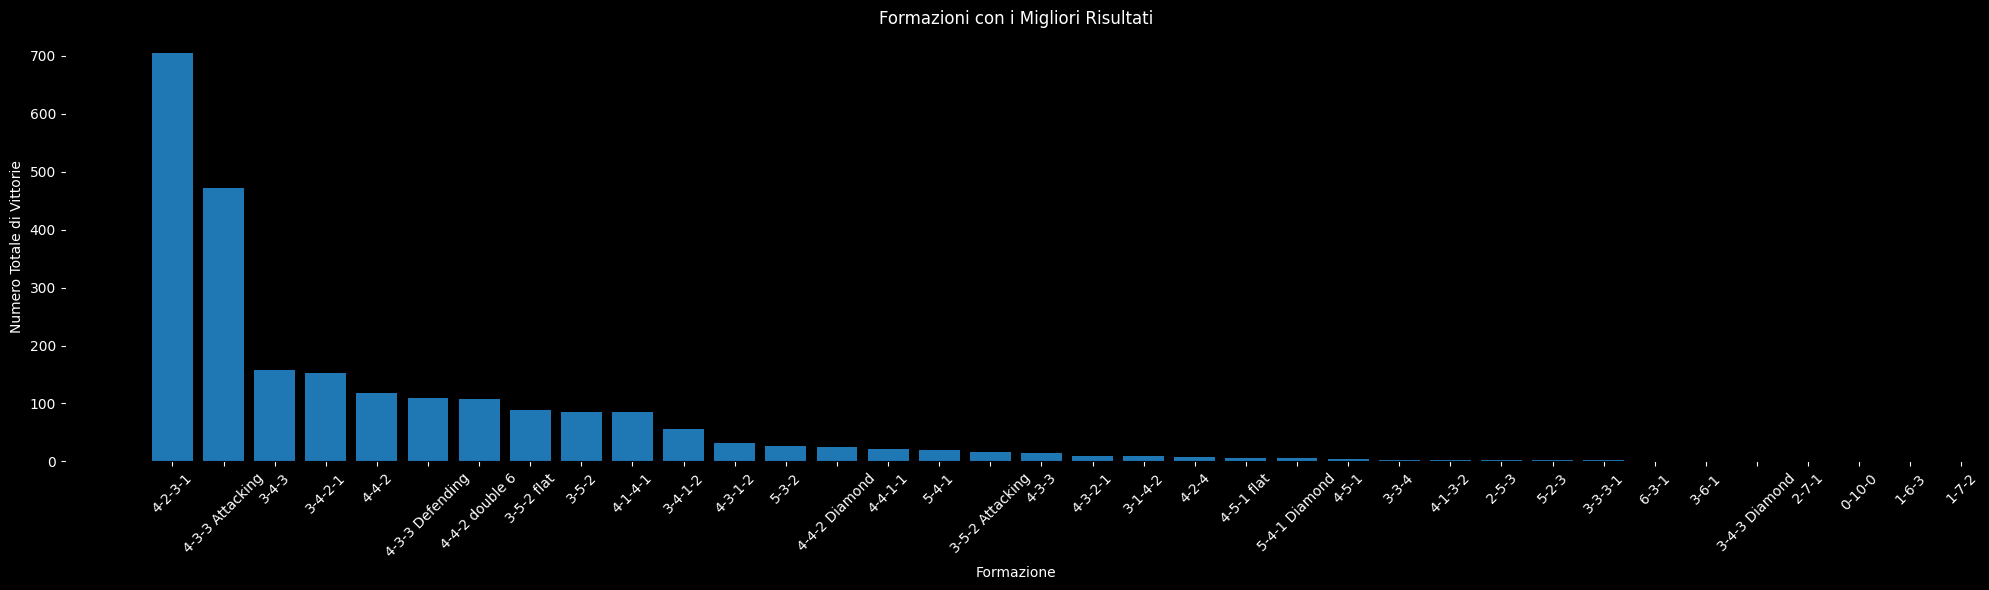

In [25]:

# Estrarre le colonne necessarie
formations_data = dataGames[['home_club_formation', 'away_club_formation', 'home_win', 'away_win', 'draw']]

# Calcolare la somma delle vittorie per ciascuna formazione in casa
home_formations_wins = formations_data.groupby('home_club_formation')['home_win'].sum().reset_index()

# Calcolare la somma delle vittorie per ciascuna formazione in trasferta
away_formations_wins = formations_data.groupby('away_club_formation')['away_win'].sum().reset_index()

total_wins = pd.merge(home_formations_wins, away_formations_wins, left_on='home_club_formation', right_on='away_club_formation', how='outer')

total_wins['total_wins'] = total_wins['home_win'] + total_wins['away_win']

# Ordinare le formazioni in base al numero totale di vittorie
total_wins = total_wins.sort_values(by='total_wins', ascending=False)

total_wins['home_club_formation'] = total_wins['home_club_formation'].astype(str)

plt.figure(figsize=(20, 6))
plt.bar(total_wins['home_club_formation'], total_wins['total_wins'])
plt.xlabel('Formazione')
plt.ylabel('Numero Totale di Vittorie')
plt.title('Formazioni con i Migliori Risultati')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###  Analizzo i dati dei club nelle competizioni 

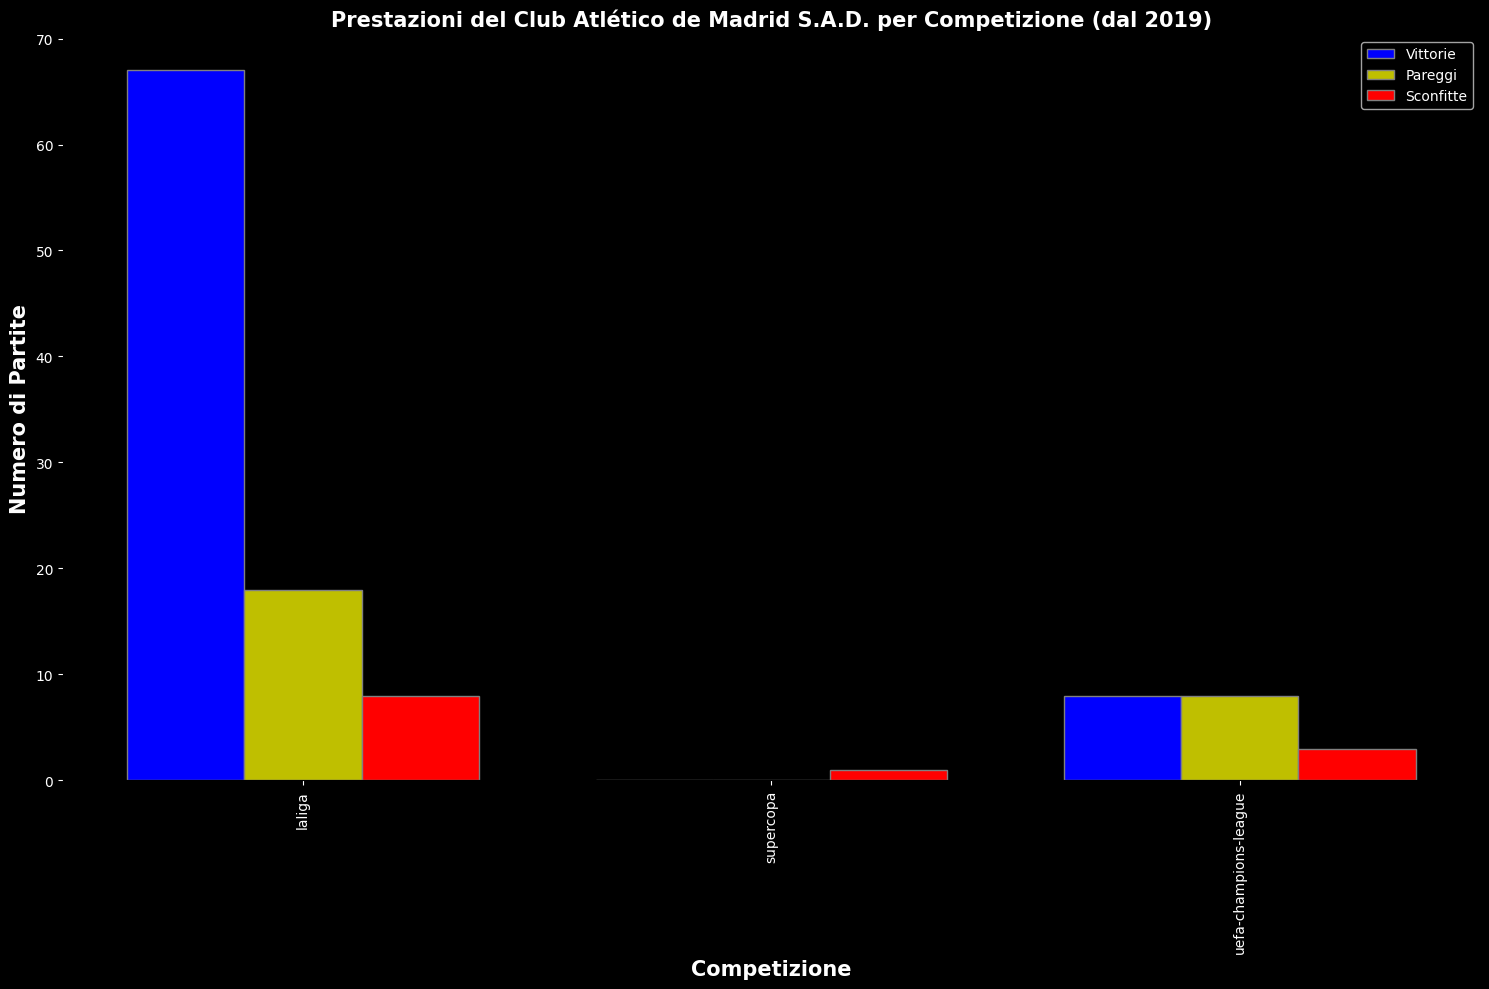

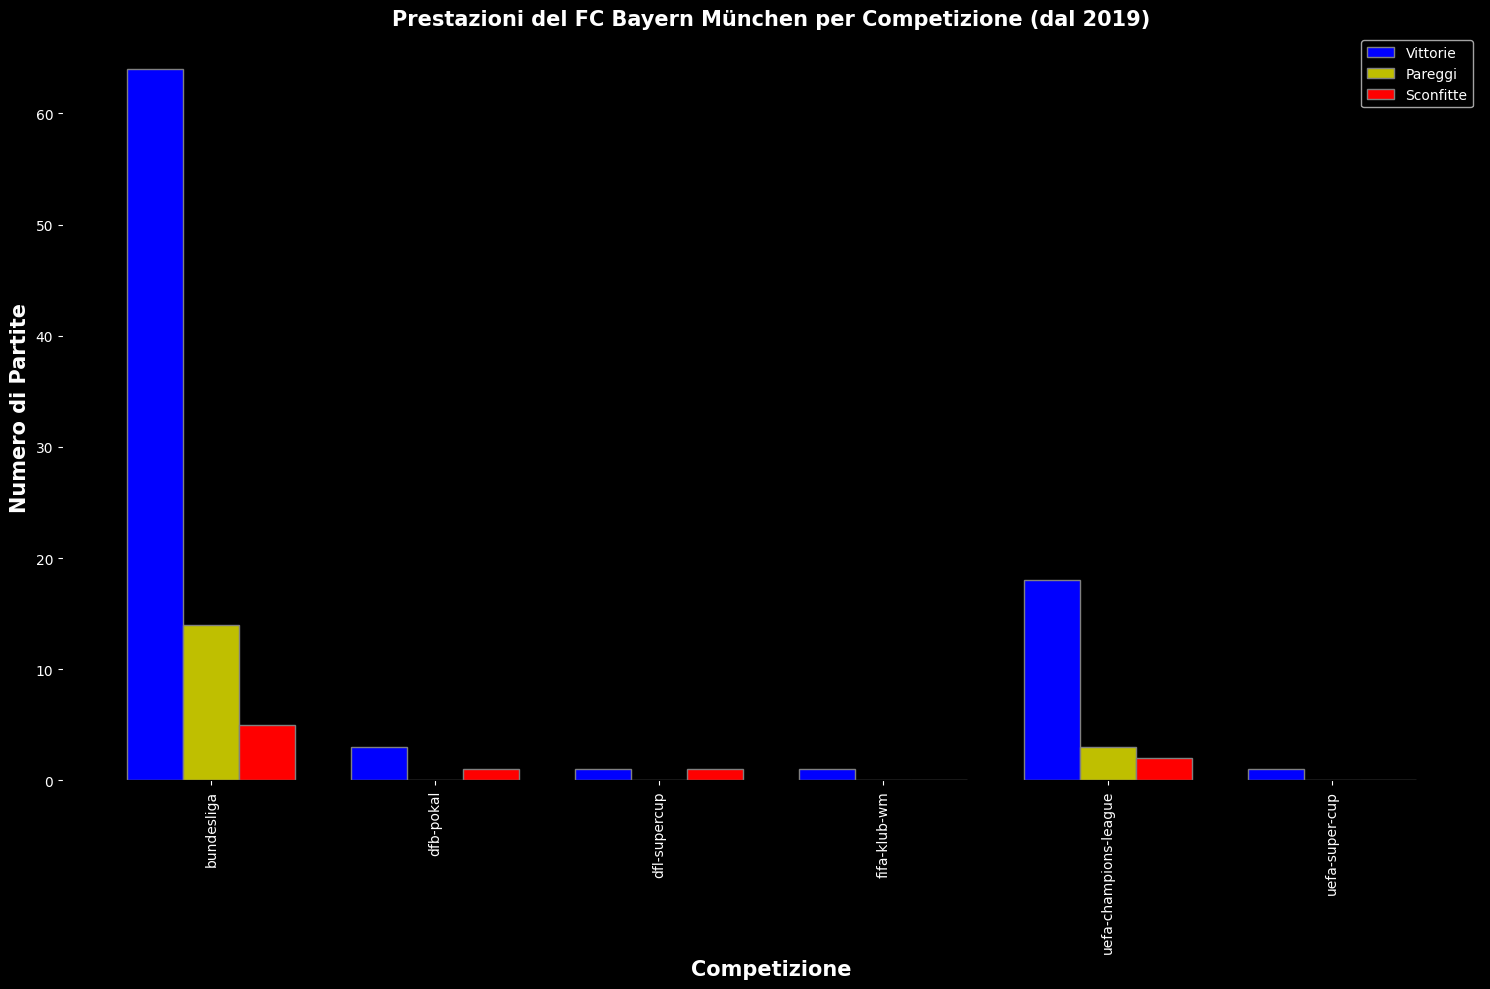

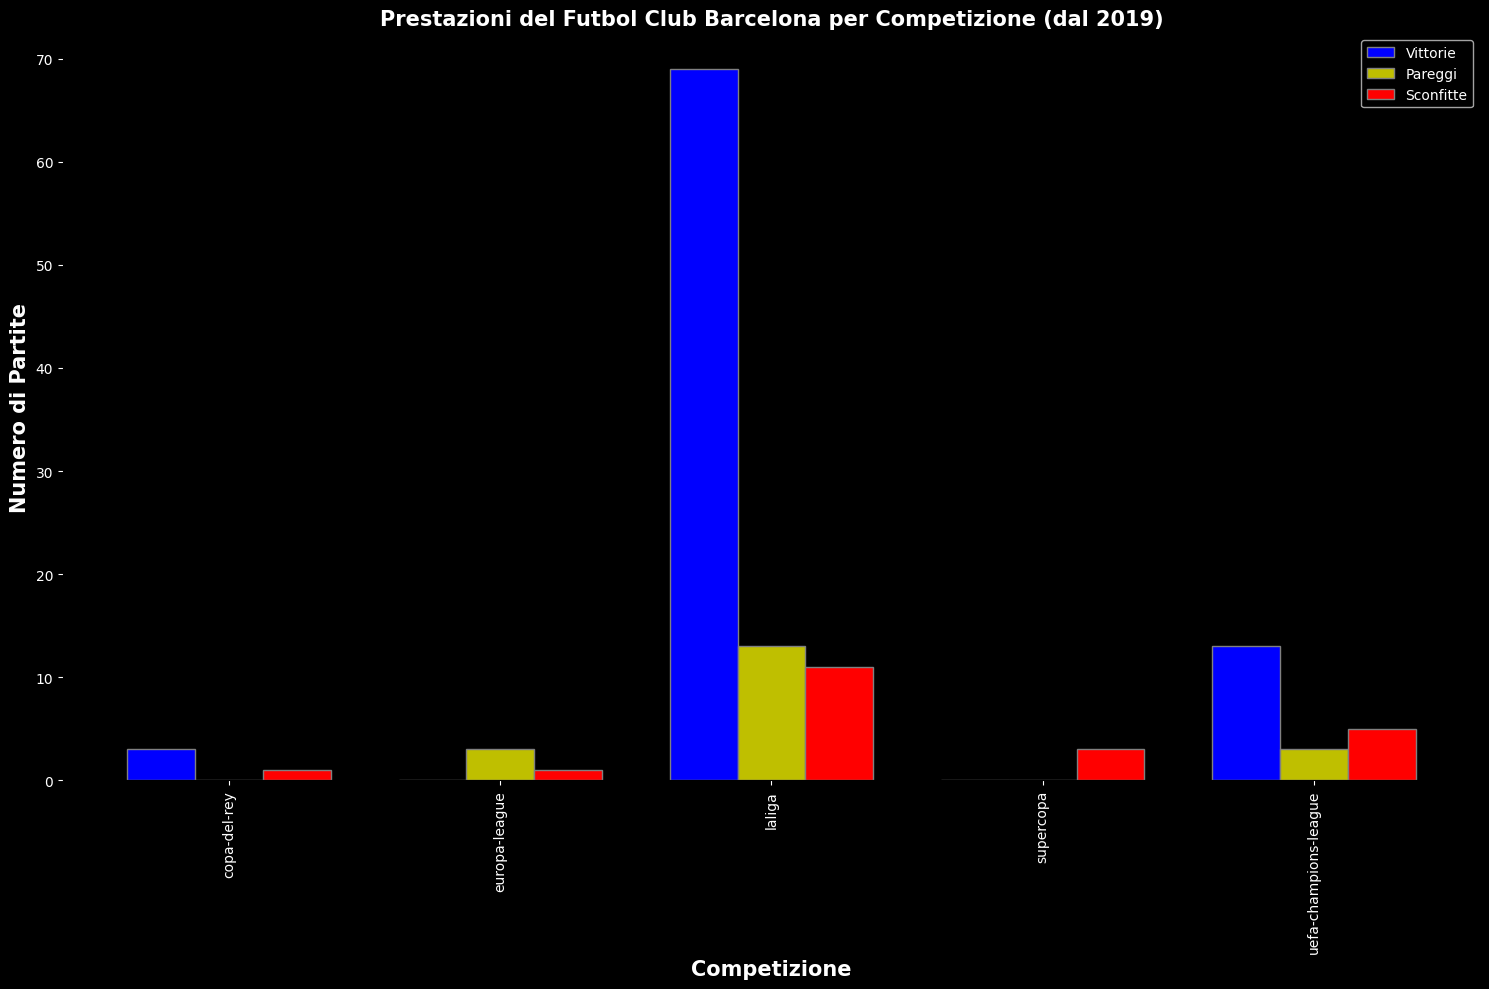

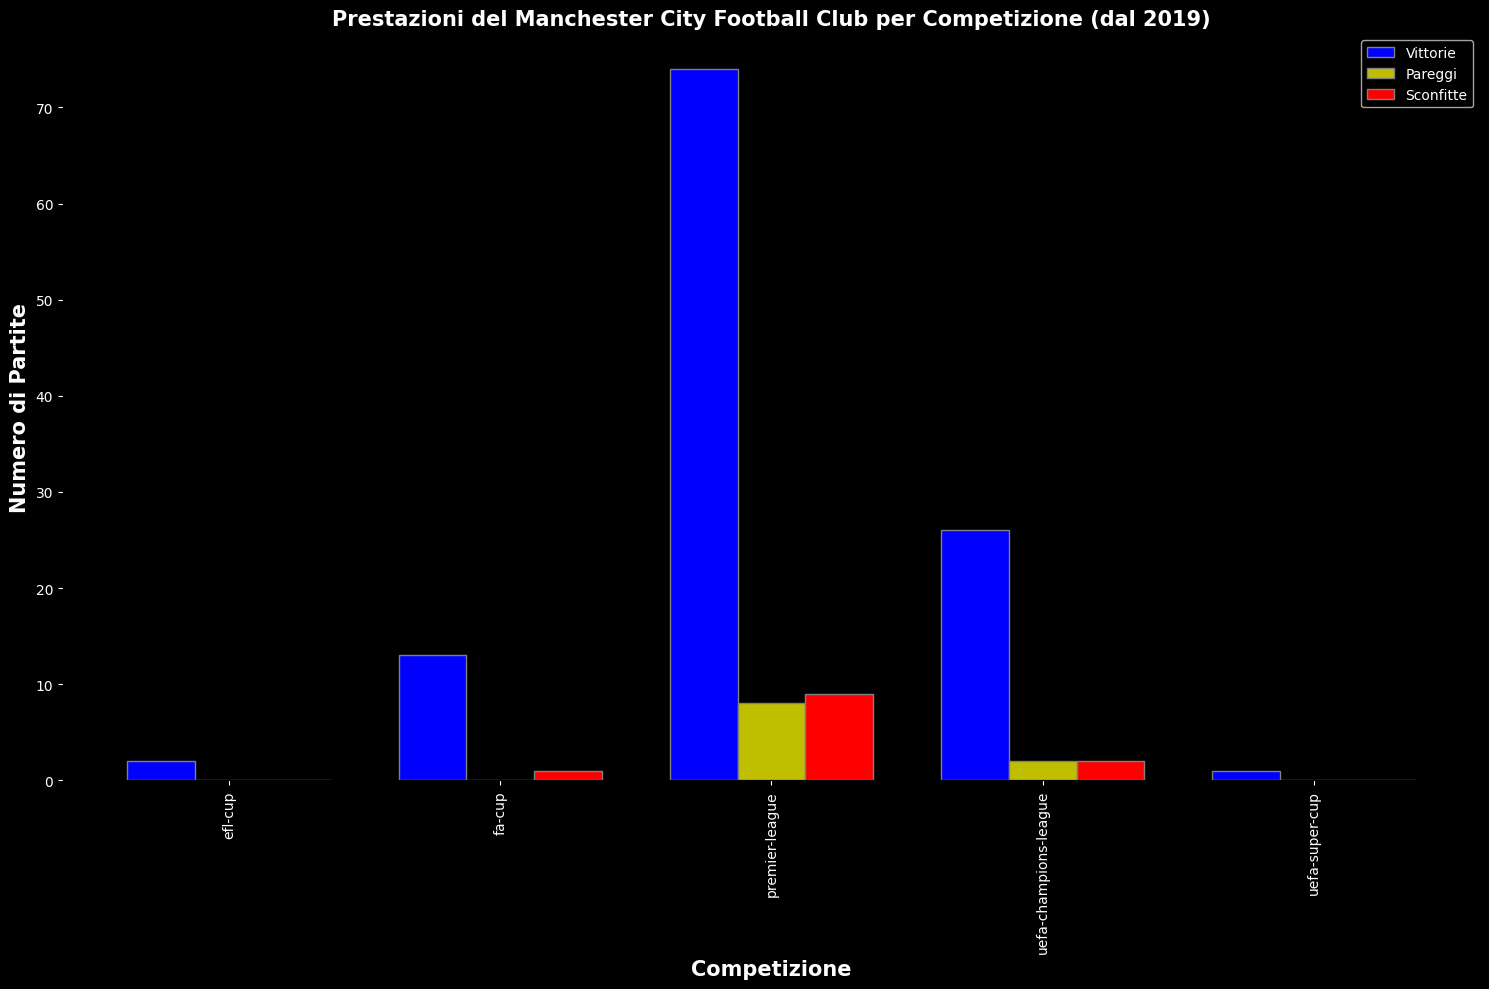

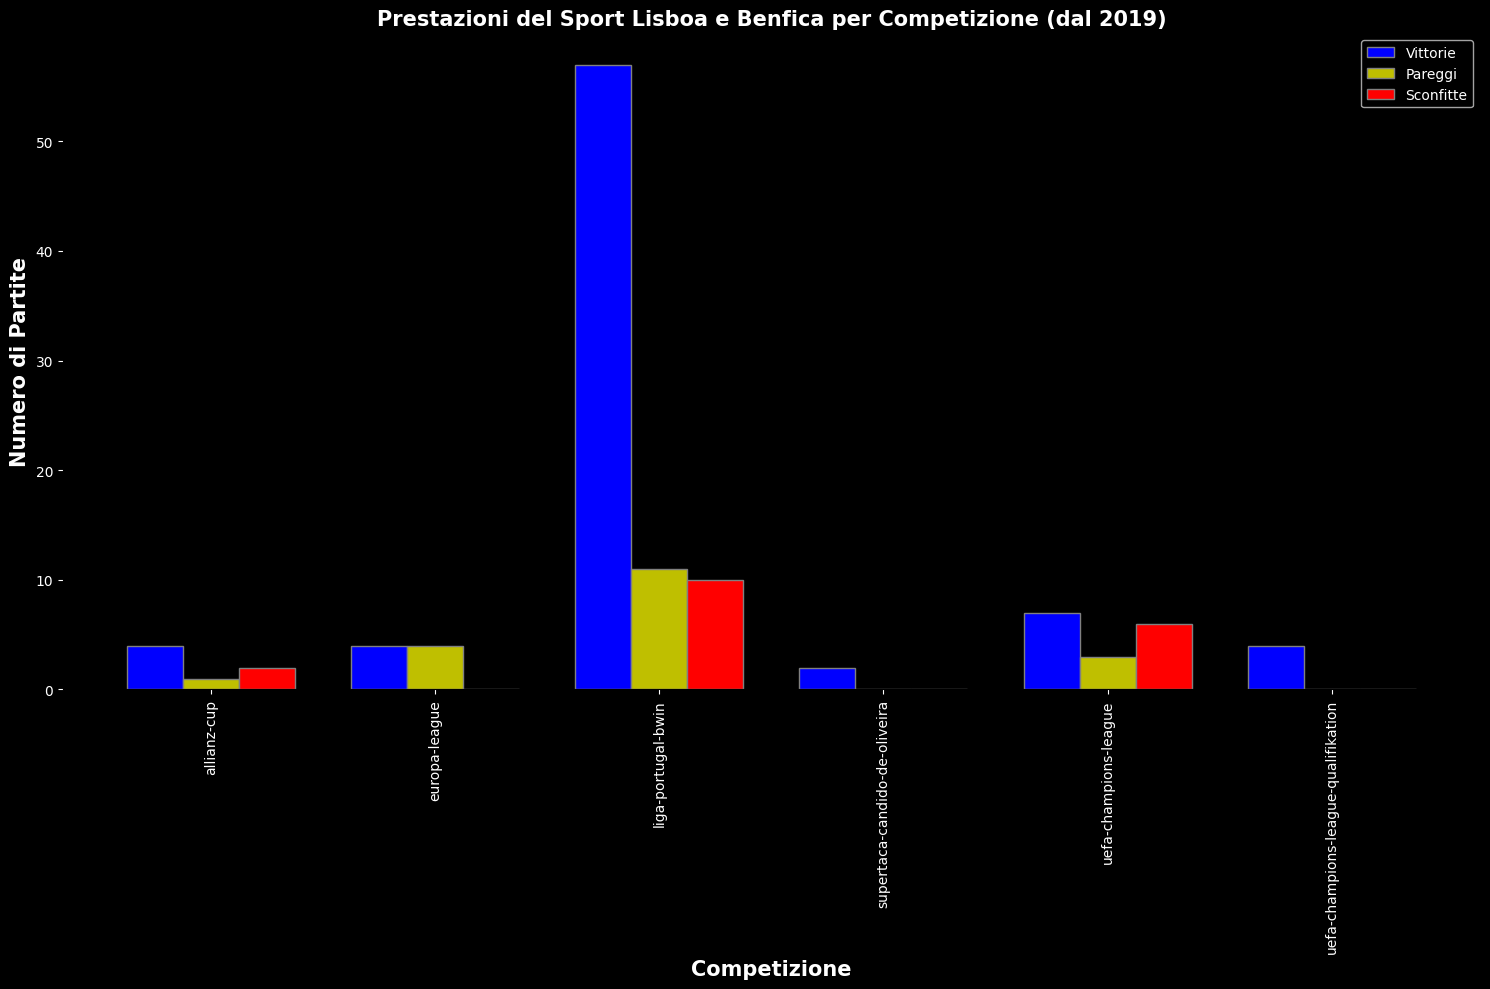

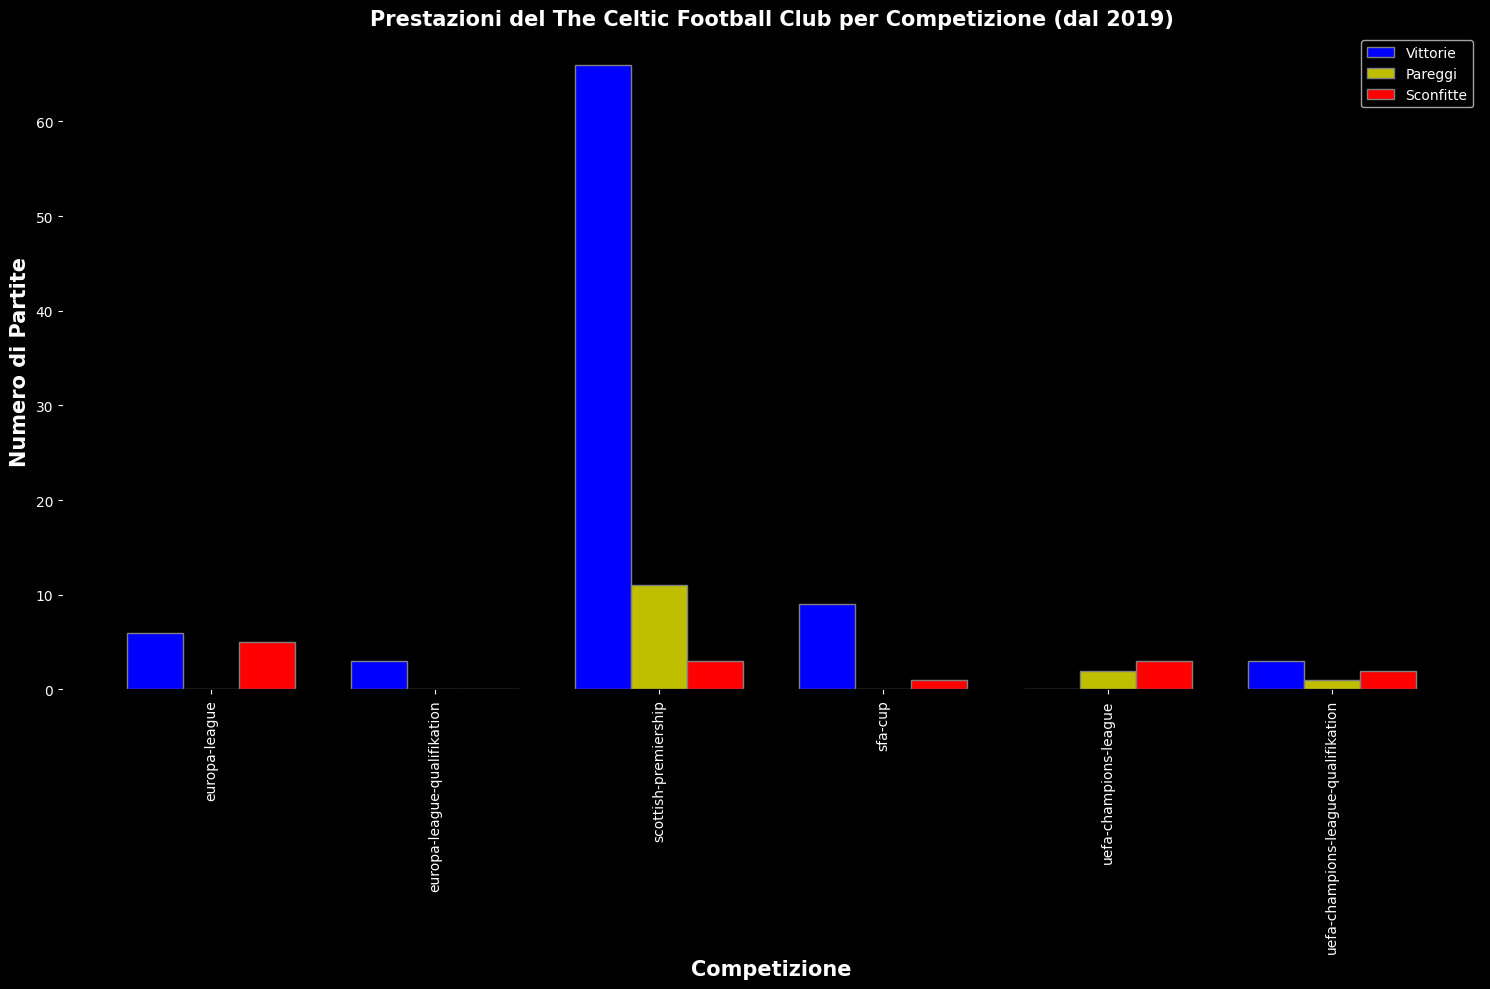

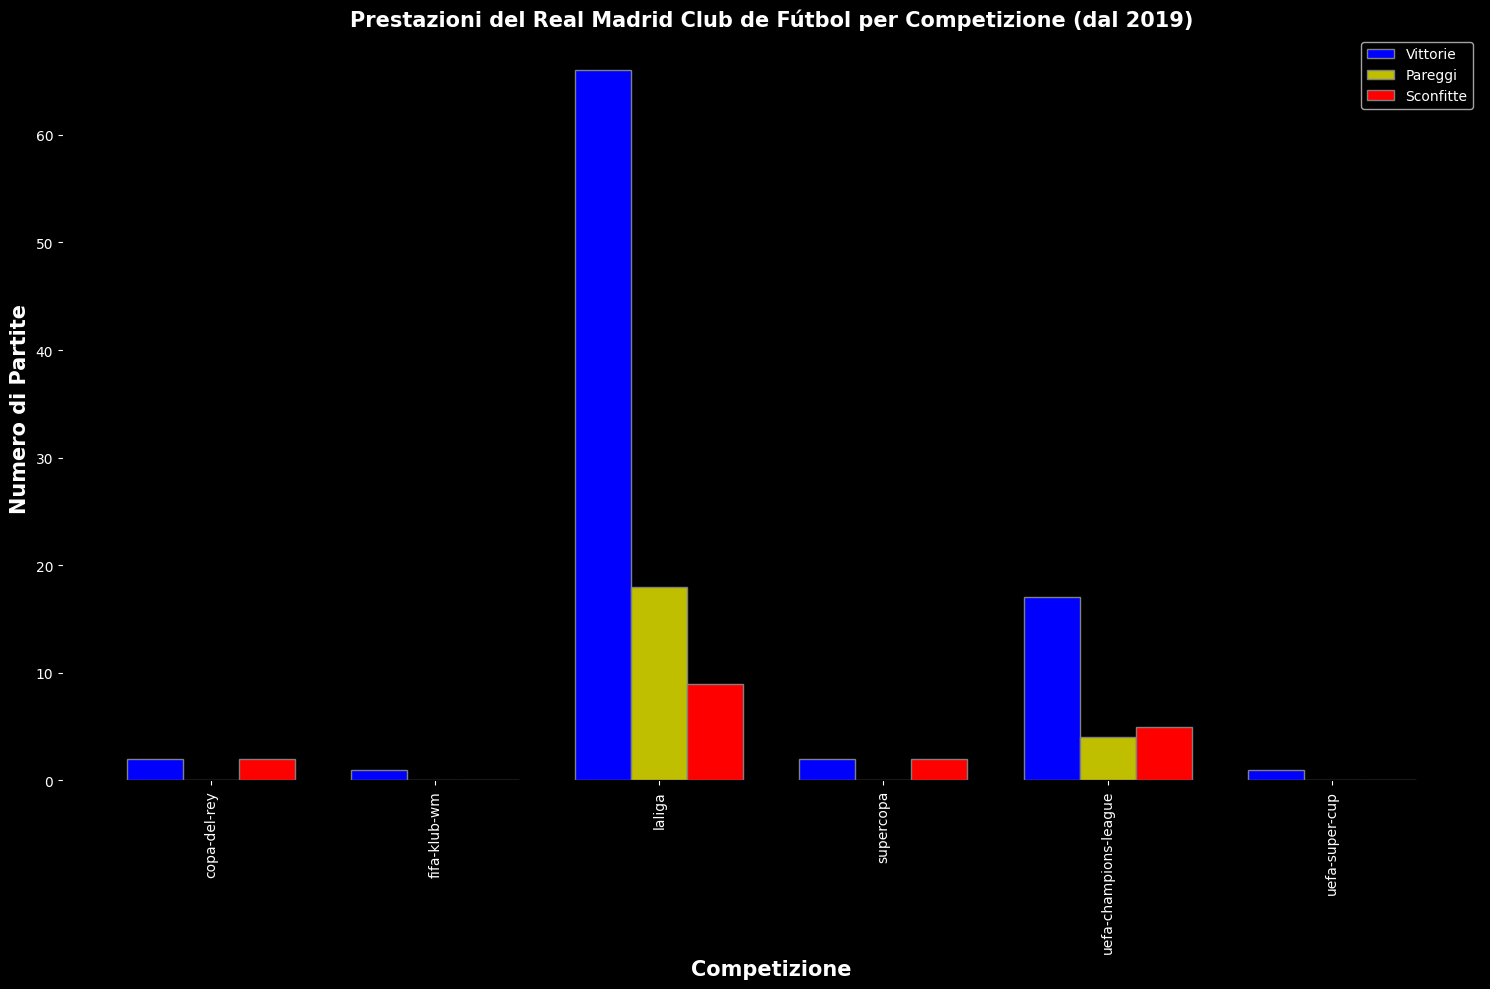

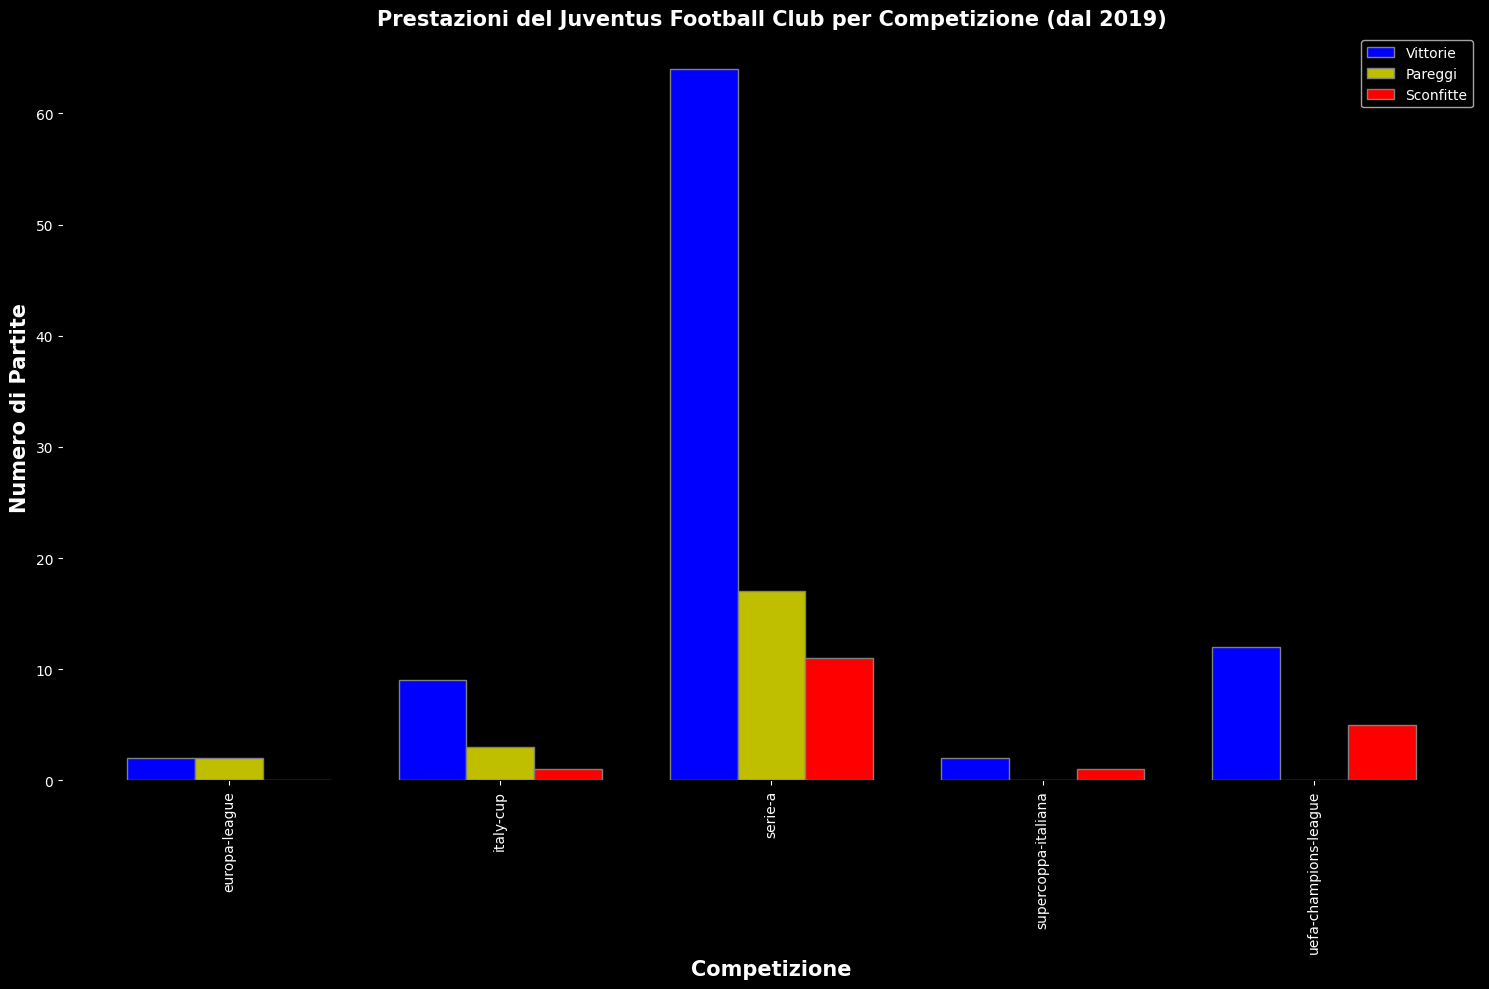

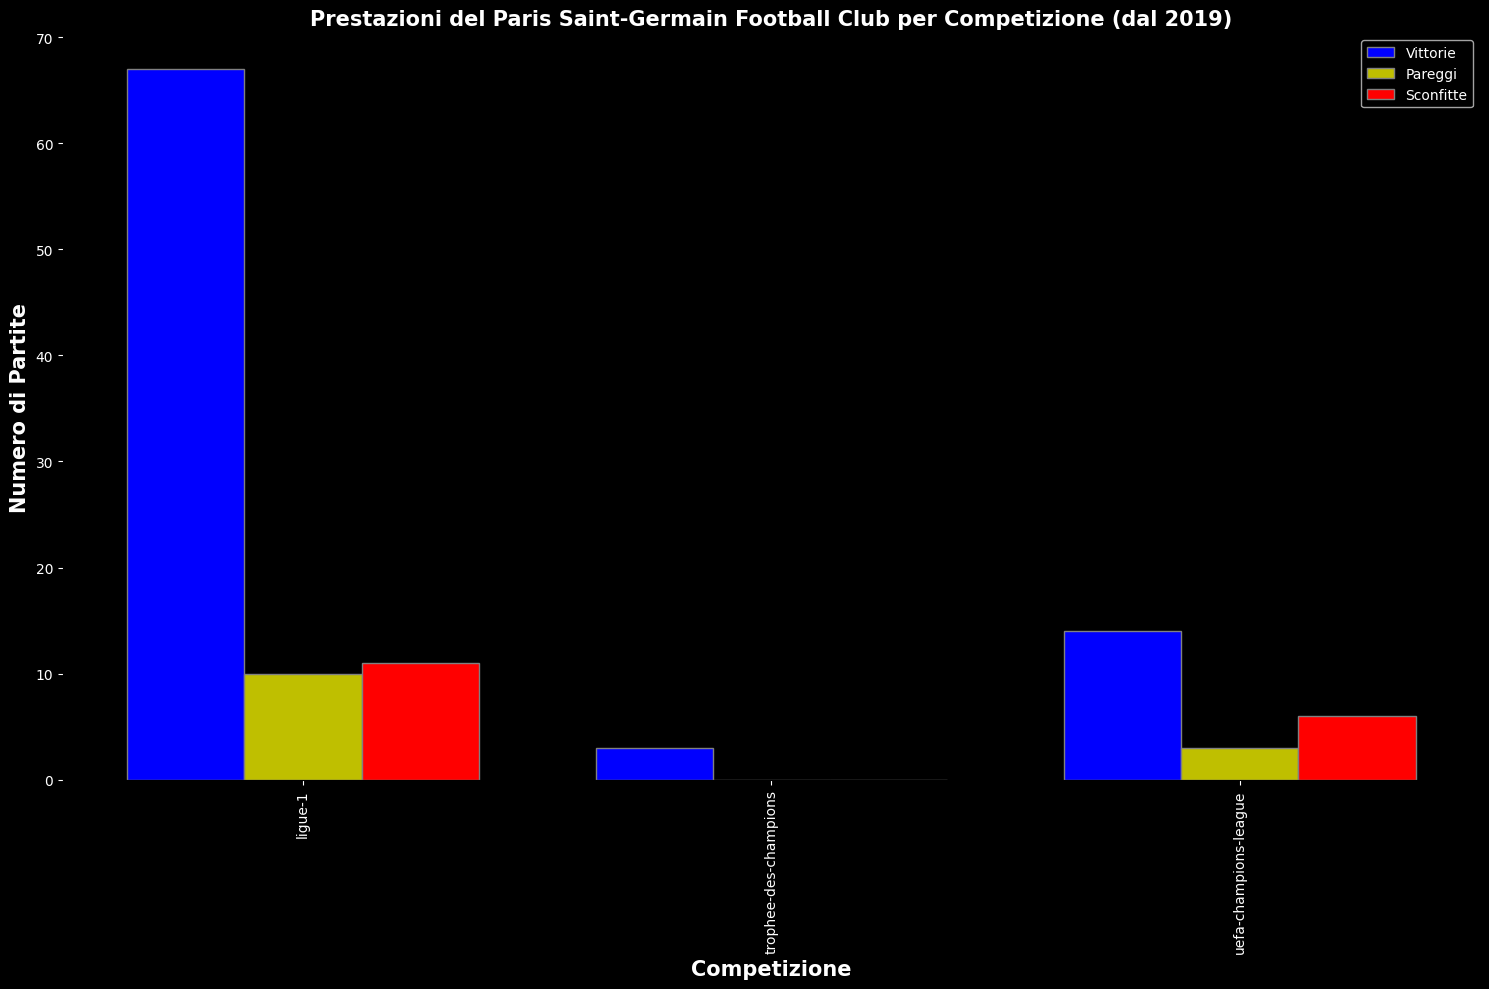

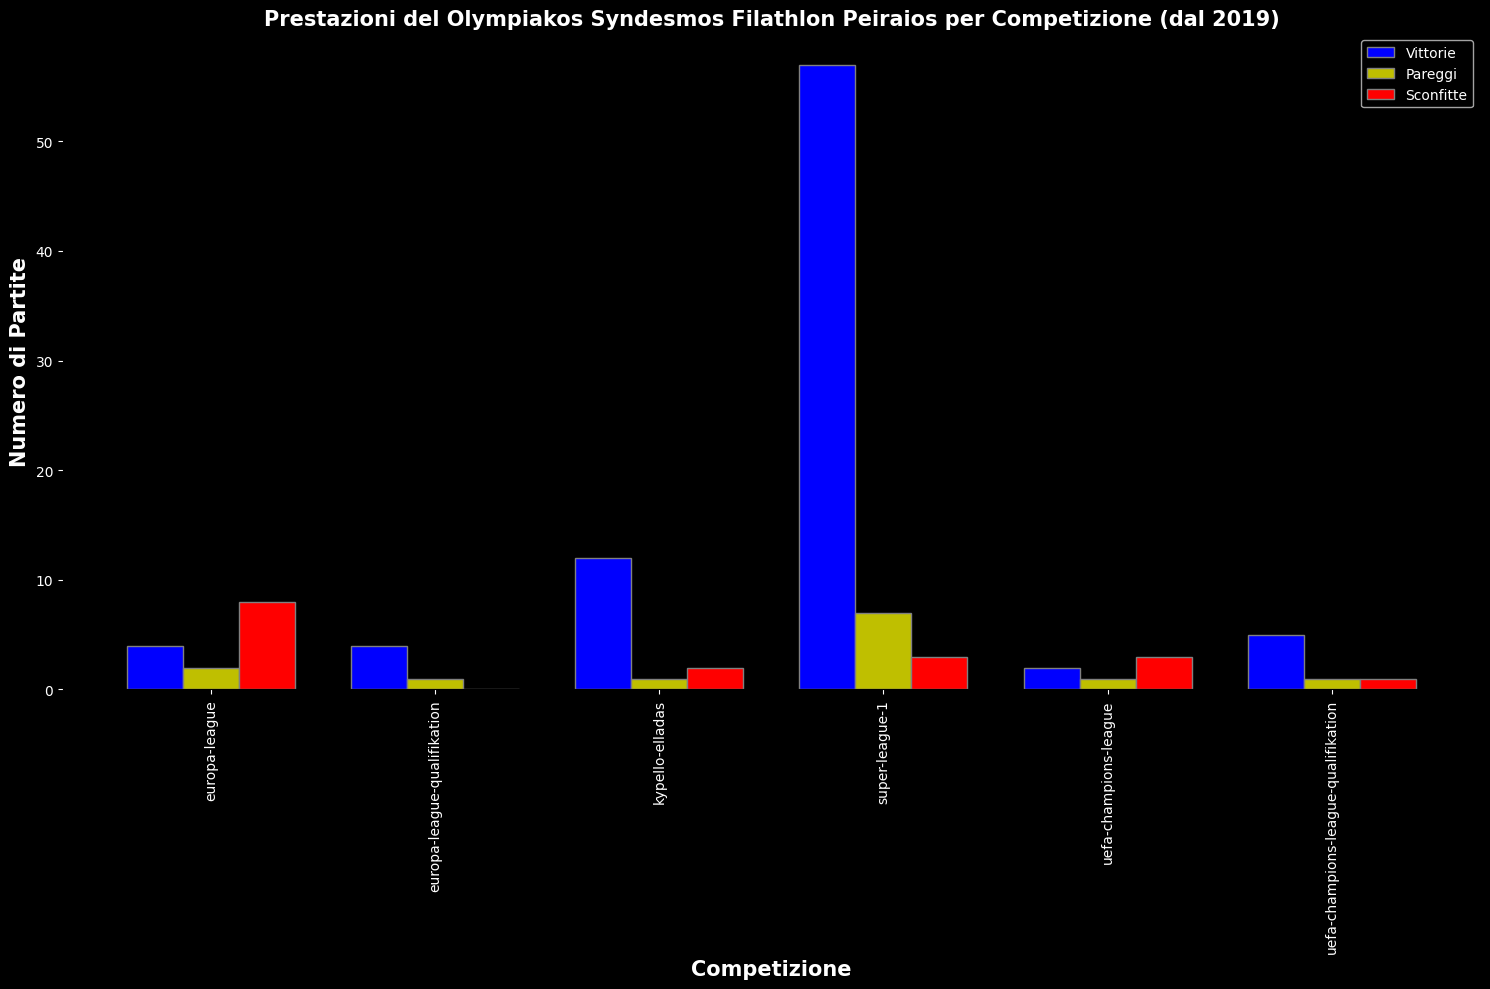

In [33]:

# Conversioni di tipo necessarie
dataGames['home_club_id'] = dataGames['home_club_id'].astype(int)
dataGames['away_club_id'] = dataGames['away_club_id'].astype(int)
club_performance_sorted['club_id'] = club_performance_sorted['club_id'].astype(int)

# Filtra le partite dal 2019 in poi
dataGames_recent = dataGames[dataGames['year'] >= 2019]

# Unisci i dati in base al club
merged_data = pd.merge(dataGames_recent, club_performance_sorted.head(10), left_on='home_club_id', right_on='club_id', how='inner')

# Unisci con i dati delle competizioni
merged_data = merged_data.merge(dataCompetitions, left_on='competition_id', right_on='competition_id', how='left')

# Calcolo delle prestazioni per club e per competizione
performance_by_club_competition = merged_data.groupby(['club_id', 'name_y']).agg(
    total_games=('game_id', 'count'),
    wins=('home_win', 'sum'),
    draws=('draw', 'sum'),
    losses=('away_win', 'sum')
).reset_index()

# Creazione di un grafico per ogni club
for club_id in performance_by_club_competition['club_id'].unique():
    # Sottoinsieme di dati per il club corrente
    club_data = performance_by_club_competition[performance_by_club_competition['club_id'] == club_id]
    
    # Creazione del grafico
    plt.figure(figsize=(15, 10))
    barWidth = 0.25

    # Set position of bar on X axis
    r1 = np.arange(len(club_data))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    # Creazione delle barre
    plt.bar(r1, club_data['wins'], color='b', width=barWidth, edgecolor='grey', label='Vittorie')
    plt.bar(r2, club_data['draws'], color='y', width=barWidth, edgecolor='grey', label='Pareggi')
    plt.bar(r3, club_data['losses'], color='r', width=barWidth, edgecolor='grey', label='Sconfitte')

    # Nome del club per il titolo (questo dovrebbe essere cambiato con il nome effettivo del club)
    club_data['name_x'] = dataClubs[dataClubs['club_id'] == club_id]['name'].values[0] 
    club_name = club_data['name_x'].values[0]

    plt.xlabel('Competizione', fontweight='bold', fontsize=15)
    plt.ylabel('Numero di Partite', fontweight='bold', fontsize=15)
    plt.xticks([r + barWidth for r in range(len(club_data))], club_data['name_y'], rotation=90)
    plt.title(f'Prestazioni del {club_name} per Competizione (dal 2019)', fontweight='bold', fontsize=15)

    plt.legend()
    plt.tight_layout()
    plt.show()


## Analisi delle Performance dei Club in Relazione alla Posizione in Classifica. 
Questa analisi mira a capire come la posizione in classifica dei club alla fine della stagione influisce sul numero di vittorie, pareggi e sconfitte nelle stagioni successive.

Per questa analisi, avremo bisogno di dati sulla posizione finale dei club nelle stagioni precedenti, che potremmo ottenere da dataGames.

In [34]:
dataGames['home_club_id'] = dataGames['home_club_id'].astype(int)
dataGames['away_club_id'] = dataGames['away_club_id'].astype(int)
club_performance_sorted['club_id'] = club_performance_sorted['club_id'].astype(int)

dataGames_recent = dataGames[dataGames['year'] >= 2019]

merged_data = pd.merge(dataGames_recent, club_performance_sorted.head(10), left_on='home_club_id', right_on='club_id', how='inner')


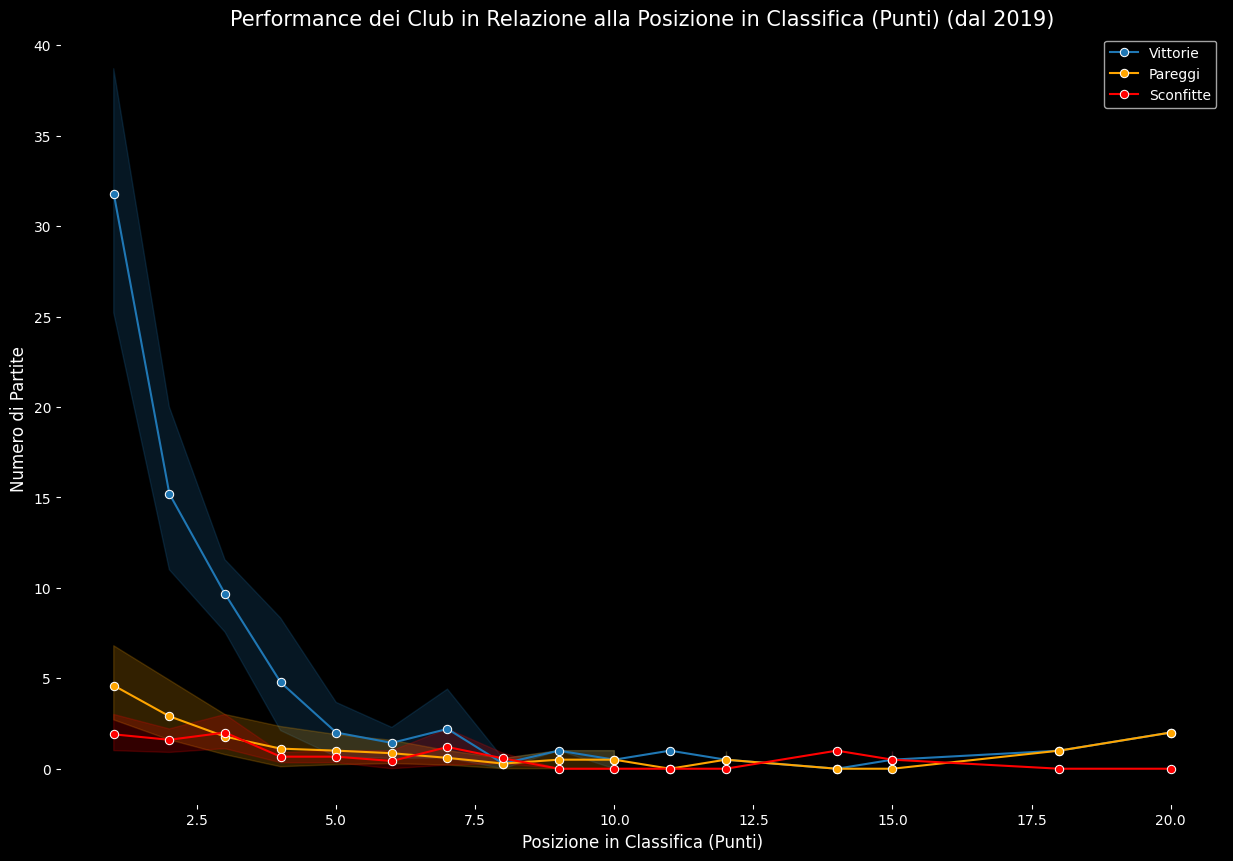

In [35]:
# Calcolo delle prestazioni in relazione alla posizione in classifica
performance_by_position = merged_data.groupby(['name', 'home_club_position']).agg(
    total_games=('game_id', 'count'),
    wins=('home_win', 'sum'),
    draws=('draw', 'sum'),
    losses=('away_win', 'sum')
).reset_index()

plt.figure(figsize=(15, 10))

# Disegna un grafico a linee per i vittorie in relazione alla posizione in classifica
sns.lineplot(data=performance_by_position, x='home_club_position', y='wins', marker='o', label='Vittorie')

# Disegna un grafico a linee per i pareggi in relazione alla posizione in classifica
sns.lineplot(data=performance_by_position, x='home_club_position', y='draws', marker='o', color='orange', label='Pareggi')

# Disegna un grafico a linee per le sconfitte in relazione alla posizione in classifica
sns.lineplot(data=performance_by_position, x='home_club_position', y='losses', marker='o', color='red', label='Sconfitte')

plt.title('Performance dei Club in Relazione alla Posizione in Classifica (Punti) (dal 2019)', fontsize=15)
plt.xlabel('Posizione in Classifica (Punti)', fontsize=12)
plt.ylabel('Numero di Partite', fontsize=12)
plt.legend()
plt.show()


Dall'analisi del grafico, che mostra la relazione tra la posizione in classifica dei club (in termini di punti) e il numero di partite vinte, pareggiate e perse, possiamo dedurre quanto segue:

#### Trend delle Vittorie (linea verde):
 Sembrerebbe che ci sia un trend decrescente nel numero di vittorie all'aumentare della posizione in classifica (indicata dai punti), il che suggerisce che i club con una posizione più alta in classifica (minori punti, che potrebbero indicare posizioni più basse in una classifica tradizionale) tendono a vincere meno partite. Questo è intuitivo, poiché i club in posizioni più basse nella classifica tendono ad avere meno punti complessivi, spesso a causa di un minor numero di vittorie.

#### Trend dei Pareggi (linea arancione):
 Il numero di pareggi sembra essere meno influenzato dalla posizione in classifica rispetto alle vittorie e alle sconfitte. La linea dei pareggi è relativamente piatta, suggerendo che la frequenza dei pareggi è più uniformemente distribuita indipendentemente dalla posizione in classifica.

#### Trend delle Sconfitte (linea rossa):
 La linea delle sconfitte mostra un picco per i club in posizioni intermedie della classifica, quindi sembra diminuire per le posizioni più alte (punti più bassi). Ciò potrebbe indicare che i club che non sono né in cima né in fondo alla classifica hanno una varianza maggiore nelle loro prestazioni, a volte perdendo contro squadre più forti mentre vincono o pareggiano contro squadre simili o più deboli.

#### Varianza (aree colorate attorno alle linee):
 Le aree colorate attorno alle linee rappresentano la varianza o l'intervallo di confidenza per il numero di vittorie, pareggi e sconfitte. L'area più ampia intorno alla linea verde per i club con una posizione più alta in classifica suggerisce una maggiore varianza nel numero di vittorie, il che potrebbe indicare che per queste squadre ci sono altri fattori che influenzano il loro numero di vittorie oltre alla loro posizione in classifica.

In conclusione, il grafico suggerisce che le squadre in posizioni più alte tendono ad avere meno vittorie, con i pareggi distribuiti più uniformemente e con un picco di sconfitte nelle posizioni intermedie. Tuttavia, è importante notare che queste tendenze devono essere interpretate con cautela poiché potrebbero essere influenzate da molti altri fattori non mostrati nel grafico, come la forza degli avversari, le condizioni di casa o trasferta, e le specifiche circostanze di ogni partita.

## Esame delle Statistiche dei Giocatori dei Club d'Élite
L'obiettivo è esaminare i club di calcio più prestigiosi concentrandosi sull'età media dei giocatori

### a. Analisi andamento dell'età dei player nei top club
generazione di un grafico che permette la visualizzazione dell'andamento dell'età dei player nei club.

/var/folders/9x/57__ff_j1wscnvbjdyy9gsrw0000gp/T/ipykernel_717/2030689345.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




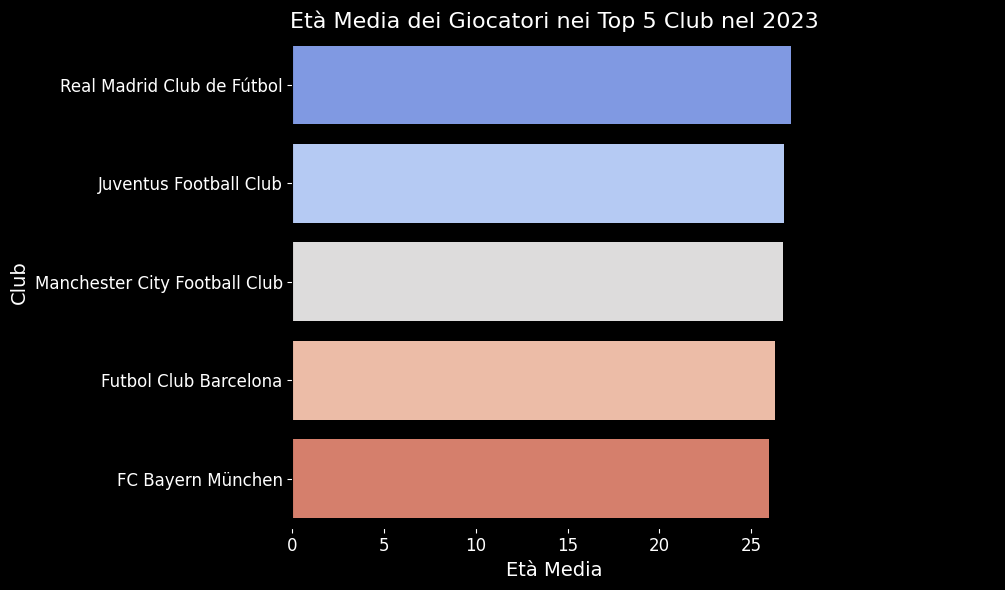

In [37]:

# 1. Pulizia e Preparazione dei Dati
top_5_clubs = club_performance_sorted.head(5)
filtered_players = dataPlayers[dataPlayers['current_club_id'].isin(top_5_clubs['club_id'].tolist())]

filtered_players['date_of_birth'] = pd.to_datetime(filtered_players['date_of_birth'], errors='coerce')

# 2. Calcolo dell'Età
filtered_players['age_in_2023'] = 2023 - filtered_players['date_of_birth'].dt.year
filtered_players = filtered_players.loc[filtered_players['last_season'] == 2023]

# 3. Preparazione dei Dati per il Grafico
age_data = filtered_players.groupby('current_club_id')['age_in_2023'].mean().reset_index()

age_data = age_data.merge(top_5_clubs[['club_id', 'name']], left_on='current_club_id', right_on='club_id')

age_data_sorted = age_data.sort_values(by='age_in_2023', ascending=False)

# 4. Creazione del Grafico
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='age_in_2023', y='name', data=age_data_sorted, palette='coolwarm')

for index, value in enumerate(age_data_sorted['age_in_2023']):
    plt.text(value, index, f' {age_data_sorted["name"].iloc[index]}', va='center', ha='left', fontsize=10, color='black')

plt.title('Età Media dei Giocatori nei Top 5 Club nel 2023', fontsize=16)
plt.xlabel('Età Media', fontsize=14)
plt.ylabel('Club', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostra il grafico
plt.tight_layout()
plt.show()


### b. analisi della provenienza dei giocatori nelle migliori squadre 

grafo di densità geografica che esprime dove si posizionano i giocatori proveniente dai top Clubs

#### Passo 1: recupero delle cordinate geografiche 

In [26]:
# Inizializza il geolocalizzatore
geolocator = Nominatim(user_agent="geoapiExercises")

# Funzione per ritardare le richieste di geocoding (per evitare il blocco)
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

def get_location(row):
    try:
        location = geocode(row['city_of_birth'])
        if location:
            return pd.Series([location.latitude, location.longitude], index=['lat', 'lon'])
    except:
        return pd.Series([None, None], index=['lat', 'lon'])

coordinates = filtered_players.apply(get_location, axis=1)

filtered_players = pd.concat([filtered_players, coordinates], axis=1)

#### Passo 2: creazione del grafico 

/var/folders/9x/57__ff_j1wscnvbjdyy9gsrw0000gp/T/ipykernel_717/4011381885.py:6: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



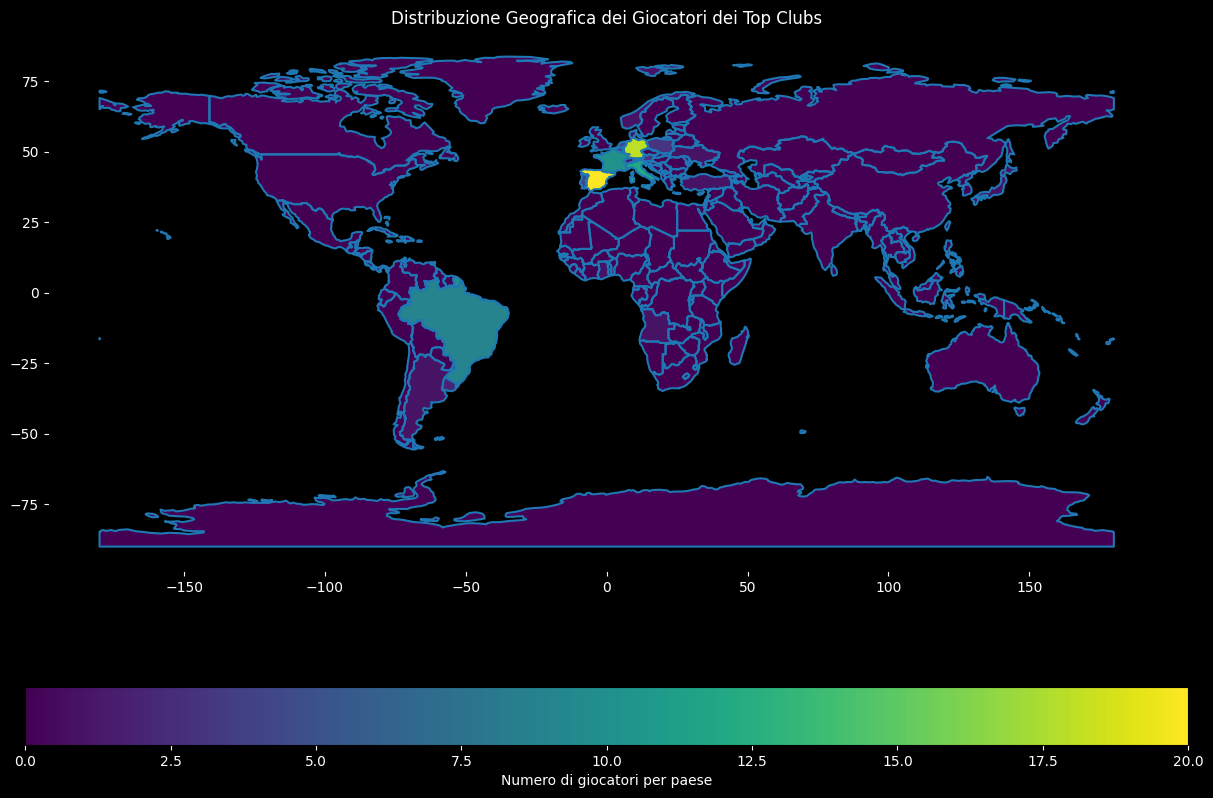

In [38]:
# Conto il numero di giocatori per paese di nascita
player_country_counts = filtered_players['country_of_birth'].value_counts().reset_index()
player_country_counts.columns = ['country', 'number_of_players']

# Carico un geodataframe con i confini dei paesi
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Uniamo i dati dei giocatori con il geodataframe
world_players = world.merge(player_country_counts, how="left", left_on="name", right_on="country")

world_players['number_of_players'] = world_players['number_of_players'].fillna(0)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_players.boundary.plot(ax=ax)
world_players.plot(column='number_of_players', ax=ax, legend=True,
                 legend_kwds={'label': "Numero di giocatori per paese",
                              'orientation': "horizontal"})
plt.title('Distribuzione Geografica dei Giocatori dei Top Clubs')
plt.show()


## Analisi delle prestazioni dei manager delle migliori squadre negli ultimi anni 



filtraggio dati delle prestazioni

In [39]:

games_2023 = dataGames[dataGames['year'] == 2023]

# Funzione per calcolare le prestazioni di ciascun manager
def calculate_manager_performance(df):
    performance_data = []
    
    for manager in df['home_club_manager_name'].unique():
        manager_games = df[(df['home_club_manager_name'] == manager) | (df['away_club_manager_name'] == manager)]
        wins = manager_games[((manager_games['home_club_manager_name'] == manager) & (manager_games['home_win'])) | 
                             ((manager_games['away_club_manager_name'] == manager) & (manager_games['away_win']))].shape[0]
        draws = manager_games[manager_games['draw']].shape[0]
        losses = manager_games.shape[0] - wins - draws
        goals_for = manager_games[manager_games['home_club_manager_name'] == manager]['home_club_goals'].sum() + \
                    manager_games[manager_games['away_club_manager_name'] == manager]['away_club_goals'].sum()
        goals_against = manager_games[manager_games['home_club_manager_name'] == manager]['away_club_goals'].sum() + \
                        manager_games[manager_games['away_club_manager_name'] == manager]['home_club_goals'].sum()

        # Aggiungi i dati delle prestazioni alla lista
        performance_data.append({
            'Manager': manager, 'Wins': wins, 'Draws': draws, 'Losses': losses, 
            'Goals For': goals_for, 'Goals Against': goals_against
        })
    
    # Crea un DataFrame dai dati raccolti
    performance = pd.DataFrame(performance_data)
    return performance

# Calcola le prestazioni dei manager
manager_performance = calculate_manager_performance(games_2023)

#### creazione dei grafici basata sui risultati ottenuti 

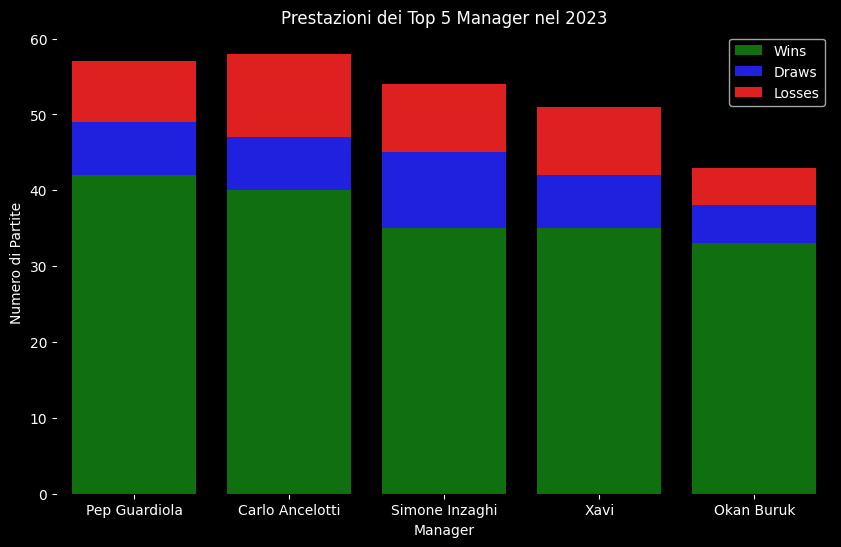

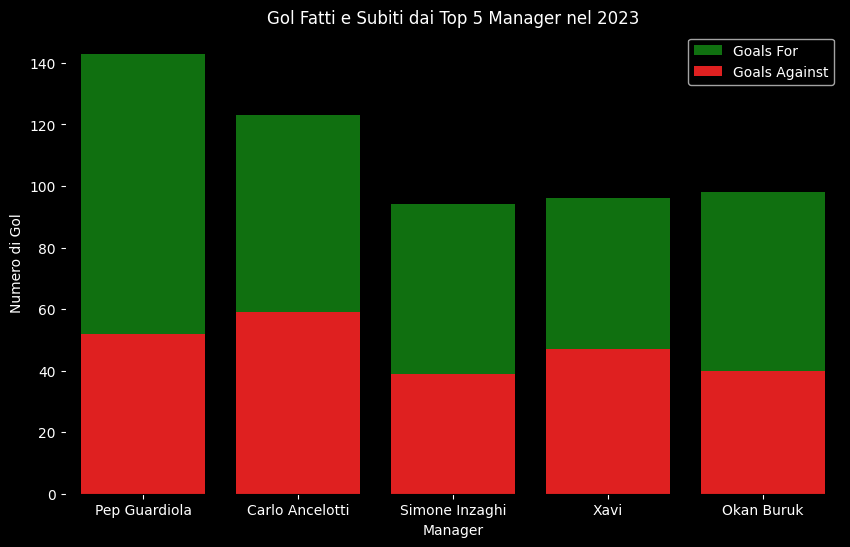

In [40]:

top_managers = manager_performance.sort_values(by='Wins', ascending=False).head(5)

# Grafico delle vittorie, pareggi e sconfitte
plt.figure(figsize=(10, 6))
sns.barplot(x='Manager', y='Wins', data=top_managers, label="Wins", color='green')
sns.barplot(x='Manager', y='Draws', data=top_managers, label="Draws", color='blue', bottom=top_managers['Wins'])
sns.barplot(x='Manager', y='Losses', data=top_managers, label="Losses", color='red', 
            bottom=top_managers['Wins'] + top_managers['Draws'])
plt.title('Prestazioni dei Top 5 Manager nel 2023')
plt.ylabel('Numero di Partite')
plt.xlabel('Manager')
plt.legend()
plt.show()

# Grafico dei gol fatti e subiti
plt.figure(figsize=(10, 6))
sns.barplot(x='Manager', y='Goals For', data=top_managers, label="Goals For", color='green')
sns.barplot(x='Manager', y='Goals Against', data=top_managers, label="Goals Against", color='red')
plt.title('Gol Fatti e Subiti dai Top 5 Manager nel 2023')
plt.ylabel('Numero di Gol')
plt.xlabel('Manager')
plt.legend()
plt.show()


## Valutazione del numero di sostituzioni dei top club nelle varie partite 


### classifica dei giocatori che sono stati sostituiti più volte 

In [46]:
# Filtrare gli eventi di tipo 'Substitutions'
substitutions = dataGamesEvents[dataGamesEvents['type'] == 'Substitutions']

# Contare quante volte ciascun player_id è stato sostituito
subs_count = substitutions['player_id'].value_counts()

# Ordinare i dati per trovare i giocatori sostituiti più spesso
most_substituted_players = subs_count.sort_values(ascending=False)
most_substituted_players = pd.merge(most_substituted_players, dataPlayers[['player_id', 'name']], left_on='player_id', right_on='player_id', how='left')

# Stampa i primi 5 giocatori che sono stati sostituiti più volte
print(most_substituted_players.head())


   player_id  count               name
0      18922    236      Karim Benzema
1      91845    220      Heung-min Son
2      45320    218     Ángel Di María
3     125781    209  Antoine Griezmann
4      65278    208              Pedro


In [51]:
dataGamesEvents

,game_event_id,date,game_id,minute,type,club_id,player_id,description,player_in_id,player_assist_id
381561,d479818b2ab79661a013c33c9ef134f4,2020-01-15,3199468,81,Substitutions,273,157501,NaN,355369.0,NaN
381562,ebc06683f832d8bd21aa291b4e7eb701,2020-01-15,3199468,48,Substitutions,1160,190338,NaN,164912.0,NaN
381563,b9c4e14503adbce55d478fd39ccb97ac,2020-01-15,3199468,71,Substitutions,273,202278,NaN,266359.0,NaN
381564,30bfa34d9ab4f04d4960a4a9c7ea9cea,2020-01-15,3199468,64,Goals,273,203507,", Left-footed shot, 6. Goal of the Season",NaN,NaN
381565,5691055bae173da5e2f0c8600326d53d,2020-01-15,3199468,80,Substitutions,273,203507,NaN,463613.0,NaN
...,...,...,...,...,...,...,...,...,...,...
666553,7f5a6b61ca858e0cd63a58c554b56bb7,2023-11-15,4228114,82,Substitutions,358,874064,", Tactical",965607.0,NaN
666554,5b93d1bc9e8bf42965682d491e1dd6c7,2023-11-15,4228114,44,Goals,46889,922572,", Penalty, 1. Tournament Goal",NaN,NaN
666555,d638b1e72f531c413487d413258a3130,2023-11-15,4228114,68,Substitutions,46889,922572,", Tactical",1200869.0,NaN
666556,0ff7774aa1383af83e40c435325463af,2023-11-15,4228114,68,Substitutions,46889,1200864,", Tactical",921121.0,NaN


In [64]:
dataGames_substitutions= dataGamesEvents
# Convertiamo la colonna 'date' nel formato datetime per poter filtrare per data
dataGames_substitutions['date'] = pd.to_datetime(dataGames_substitutions['date'])

# Filtriamo il dataframe per eventi a partire dal 2019
dataGames_substitutions = dataGames_substitutions[dataGames_substitutions['date'].dt.year > 2018]

# Concentriamoci sui dati relativi alle sostituzioni
substitutions = dataGames_substitutions[dataGames_substitutions['type'] == 'Substitutions']

# Controlliamo la struttura dei dati relativi alle sostituzioni
substitutions.dropna(subset=['description'], inplace=True)

In [66]:
substitutions= pd.merge(substitutions, dataClubs[['club_id', 'name']], left_on='club_id', right_on='club_id', how='left')

 ## Analisi delle motivazioni delle sostituzioni
 grafico mostra il conteggio delle diverse motivazioni per le sostituzioni nel dataset fornito. Da questo estratto del dataset, sembra che molte sostituzioni siano state fatte per motivi "Tattici".
 Molte meno sostituzioni per motivi di infortunio.

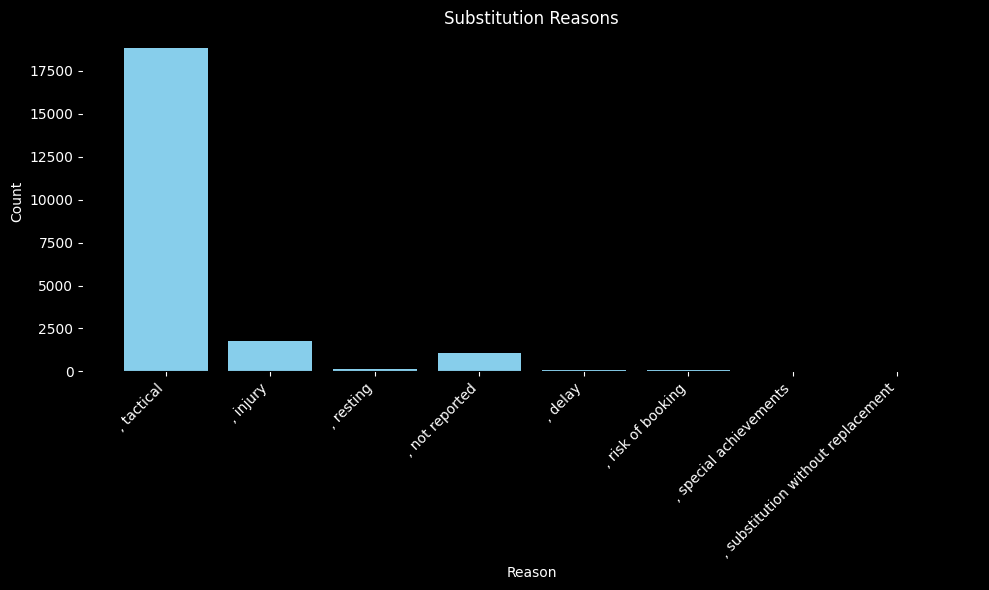

In [63]:

df = pd.DataFrame(substitutions)

# Count the occurrences of each substitution reason
substitution_reasons = Counter(df['description'].str.strip().str.lower())

# Prepare data for plotting
labels, values = zip(*substitution_reasons.items())

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='skyblue')
plt.title('Substitution Reasons')
plt.xlabel('Reason')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()


## Analisi dei club che effettuano il maggior numero di sostituzioni

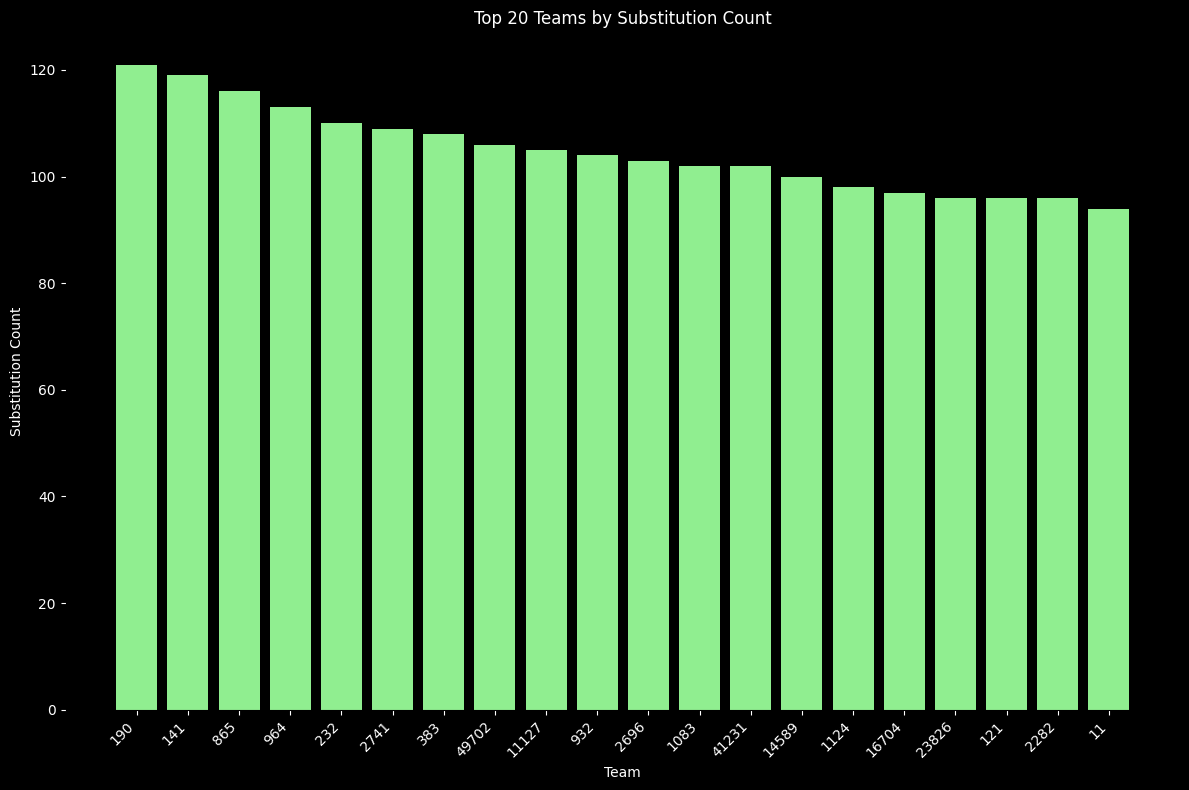

In [73]:
df_update = pd.DataFrame(substitutions)

# Sort the team substitutions by count in descending order and pick the top 20
top_teams_substitutions = Counter(df_update['club_id']).most_common(20)

# Prepare data for plotting for the top 20 teams
top_teams, top_substitution_counts = zip(*top_teams_substitutions)

# Convert top team names to string explicitly if they are not
top_teams_str = [str(team) for team in top_teams]

# Create the plot for the top 20 teams
plt.figure(figsize=(12, 8))
plt.bar(top_teams_str, top_substitution_counts, color='lightgreen')
plt.title('Top 20 Teams by Substitution Count')
plt.xlabel('Team')
plt.ylabel('Substitution Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()


In [76]:
df_update


,game_event_id,date,game_id,minute,type,club_id,player_id,description,player_in_id,player_assist_id,name_x,name_y
0,e43f8afde54bae45f3f7af4900a27a99,2021-09-22,3606208,78,Substitutions,660,59970,", Tactical",468301.0,NaN,FC Shakhtar Donetsk,FC Shakhtar Donetsk
1,331b486ff497963d57ad4da3e4d85185,2021-09-22,3606208,67,Substitutions,660,68778,", Tactical",74089.0,NaN,FC Shakhtar Donetsk,FC Shakhtar Donetsk
2,d642bef5e43114201189dc40f69da238,2021-09-22,3606208,67,Substitutions,660,124028,", Tactical",396638.0,NaN,FC Shakhtar Donetsk,FC Shakhtar Donetsk
3,b627d5488abe6e08db78d1ea8011d884,2021-09-22,3606208,66,Substitutions,338,124182,", Tactical",207074.0,NaN,Futbolniy Klub Dynamo Kyiv,Futbolniy Klub Dynamo Kyiv
4,ed8422a7cccded2c51f51d810ea2a4ee,2021-09-22,3606208,67,Substitutions,338,181118,", Tactical",59322.0,NaN,Futbolniy Klub Dynamo Kyiv,Futbolniy Klub Dynamo Kyiv
...,...,...,...,...,...,...,...,...,...,...,...,...
21856,7b89ec7d57033c6783b80a4ab248b947,2023-11-15,4228114,59,Substitutions,46889,814815,", Tactical",550816.0,NaN,NaN,NaN
21857,503bec0b5797d85f747a4aaf1c23b308,2023-11-15,4228114,63,Substitutions,46889,839808,", Injury",1203716.0,NaN,NaN,NaN
21858,7f5a6b61ca858e0cd63a58c554b56bb7,2023-11-15,4228114,82,Substitutions,358,874064,", Tactical",965607.0,NaN,NaN,NaN
21859,d638b1e72f531c413487d413258a3130,2023-11-15,4228114,68,Substitutions,46889,922572,", Tactical",1200869.0,NaN,NaN,NaN
